# Setup

In [1]:
import albumentations as A
import copy
import cv2
import math
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import unittest
from albumentations.pytorch import ToTensorV2
from PIL import Image, ImageFile
from torch.utils.data import Dataset, DataLoader
from torchvision.ops import nms, box_iou, box_convert
from tqdm.notebook import tqdm, trange

# Config

In [5]:
class Config:

  def __init__(self):
    self.BB_TRESHOLD = 50 #defines whats considered a large boundingbox for the filtering of the data
    self.dataSplit = [0.7, 0.1, 0.2] #train, evaluation, test
    self.numOfIm = 12880 + 3226 -1 #total num of images in dataset.
    self.DATA_PATH = '../wider_face/'
    self.INDEX_PATH_TRAIN = self.DATA_PATH + 'annotation/wider_face_train_bbx_gt.txt'
    self.INDEX_PATH_VAL = self.DATA_PATH + 'annotation/wider_face_val_bbx_gt.txt'
    self.INDEX_PATH_ALL = self.DATA_PATH + 'annotation/wider_face_all.txt'
    self.IMAGE_STORE_PATH_TRAIN = self.DATA_PATH + 'train/'
    self.IMAGE_STORE_PATH_VAL = self.DATA_PATH + 'validation/'
    self.ANCHORS = [
      [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
      [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
      [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)],
    ]  # Note these have been rescaled to be between [0, 1]
  

    #TODO replace these by what we use
    self.DATASET = '/PASCAL_VOC'
    self.IMG_DIR = '/PASCAL_VOC/images/'
    self.LABEL_DIR = '/PASCAL_VOC/labels/'
    self.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

    # UTILS.seed_everything()  # If you want deterministic behavior
    self.NUM_WORKERS = 0 #4 causes errors on windows to have more than 0
    self.BATCH_SIZE = 10
    self.IMAGE_SIZE = 416
    self.LEARNING_RATE = 1e-4
    self.WEIGHT_DECAY = 1e-4 #staat uit nu om te overfitten, kan aan tijdens echte trainen
    self.NUM_EPOCHS = 100
    self.CONF_THRESHOLD = 0.7#0.05
    self.MAP_IOU_THRESH = 0.25#0.5
    self.NMS_IOU_THRESH = 0.25#0.45
    self.S = [self.IMAGE_SIZE // 32, self.IMAGE_SIZE // 16, self.IMAGE_SIZE // 8]
    self.PIN_MEMORY = True
    self.LOAD_CHECKPOINT = True
    self.SAVE_MODEL = True
    self.SAVE_RESULTS = True
    self.CHECKPOINT_PATH = "../checkpoints/"
    self.RESULTS_PATH = "results/"
    self.TINY_MAP_AREA = 0.01
    
    self.ANCHORS = [
        [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
        [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
        [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)],
    ]  # Note these have been rescaled to be between [0, 1]
    
    self.scale = 1.1
    self.train_transforms = A.Compose(
        [
            A.LongestMaxSize(max_size=int(self.IMAGE_SIZE * self.scale)),
            A.PadIfNeeded(
                min_height=int(self.IMAGE_SIZE * self.scale),
                min_width=int(self.IMAGE_SIZE * self.scale),
                border_mode=cv2.BORDER_CONSTANT,
            ),
            A.RandomCrop(width=self.IMAGE_SIZE, height=self.IMAGE_SIZE),
            A.ColorJitter(brightness=0.6, contrast=0.6, saturation=0.6, hue=0.6, p=0.4),
            A.HorizontalFlip(p=0.5),
            A.Blur(p=0.1),
            A.CLAHE(p=0.1),
            A.Posterize(p=0.1),
            A.ToGray(p=0.1),
            A.ChannelShuffle(p=0.05),
            A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255,),
            ToTensorV2(),
        ],
        bbox_params=A.BboxParams(format="coco", min_visibility=0.4, label_fields=[],),
    )

    self.test_transforms = A.Compose(
        [
            A.LongestMaxSize(max_size=self.IMAGE_SIZE),
            A.PadIfNeeded(
                min_height=self.IMAGE_SIZE, min_width=self.IMAGE_SIZE, border_mode=cv2.BORDER_CONSTANT
            ),
            A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255,),
            ToTensorV2(),
        ],
        bbox_params=A.BboxParams(format="coco", min_visibility=0.4, label_fields=[]),
    )

CONFIG = Config()

# YOLOv3 Architecture

In [6]:
"""
Implementation of YOLOv3 architecture
"""
"""
Information about architecture config:
Tuple is structured by (filters, kernel_size, stride)
Every conv is a same convolution.
List is structured by "B" indicating a residual block followed by the number of repeats
"S" is for scale prediction block and computing the yolo loss
"U" is for upsampling the feature map and concatenating with a previous layer
"""
config = [
    (32, 3, 1),
    (64, 3, 2),
    ["B", 1],
    (128, 3, 2),
    ["B", 2],
    (256, 3, 2),
    ["B", 8],
    (512, 3, 2),
    ["B", 8],
    (1024, 3, 2),
    ["B", 4],  # To this point is Darknet-53
    (512, 1, 1),
    (1024, 3, 1),
    "S",
    (256, 1, 1),
    "U",
    (256, 1, 1),
    (512, 3, 1),
    "S",
    (128, 1, 1),
    "U",
    (128, 1, 1),
    (256, 3, 1),
    "S",
]


class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, bn_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels,
                              bias=not bn_act, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.leaky = nn.LeakyReLU(0.1)
        self.use_bn_act = bn_act

    def forward(self, x):
        if self.use_bn_act:
            return self.leaky(self.bn(self.conv(x)))
        else:
            return self.conv(x)


class ResidualBlock(nn.Module):
    def __init__(self, channels, use_residual=True, num_repeats=1):
        super().__init__()
        self.layers = nn.ModuleList()
        for repeat in range(num_repeats):
            self.layers += [
                nn.Sequential(
                    CNNBlock(channels, channels // 2, kernel_size=1),
                    CNNBlock(channels // 2, channels,
                             kernel_size=3, padding=1),
                )
            ]

        self.use_residual = use_residual
        self.num_repeats = num_repeats

    def forward(self, x):
        for layer in self.layers:
            if self.use_residual:
                x = x + layer(x)
            else:
                x = layer(x)

        return x


class ScalePrediction(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.pred = nn.Sequential(
            CNNBlock(in_channels, 2 * in_channels, kernel_size=3, padding=1),
            CNNBlock(
                2 * in_channels, 5 * 3, bn_act=False, kernel_size=1
            ),
        )

    def forward(self, x):
        return (
            self.pred(x)
            .reshape(x.shape[0], 3, 5, x.shape[2], x.shape[3])
            .permute(0, 1, 3, 4, 2)
        )

# This module applies the math opperations from the YOLO paper to retrieve the true coordinates and with and height of the bboxes instead of doing this at a later stage.


class MathOperations(nn.Module):
    def __init__(self):
        super().__init__()
        self.sigmoid = nn.Sigmoid()
        self.anchors = (torch.tensor(CONFIG.ANCHORS) * torch.tensor(
            CONFIG.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)).to(CONFIG.DEVICE)

    """

    x is in the shape N x 3 x S x S x 5
    we want the last dimension to be in this order: [x, y, w, h, obj]
    In the forward we'll apply the mathematical operations described in both YOLO 9000 and YOLO V3 papers

    bx = sigma(tx) + cx
    by = sigma(ty) + cy
    bw = pw * exp(tw)
    bh = ph * exp(th)

    cx/cy = location of upper left corner of cell
    pw/ph = prior size of the anchor box
    t = vector before operation
    b = vector after operation

    """

    def forward(self, x, scale):
        # return  torch.cat([self.sigmoid(predictions[..., 1:3]), torch.exp(predictions[..., 3:5]) * anchors], dim=-1)
        return torch.cat([self.sigmoid(x[..., 0:2]), torch.exp(x[..., 2:4]) * self.anchors[scale].reshape(1, 3, 1, 1, 2), self.sigmoid(x[..., 4:5])], dim=-1)


class YOLOv3(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.in_channels = in_channels
        self.layers = self._create_conv_layers()

    def forward(self, x):
        outputs = []  # for each scale
        route_connections = []
        MathOperationsLayer = MathOperations()
        for layer in self.layers:
            if isinstance(layer, ScalePrediction):
                outputs.append(MathOperationsLayer(layer(x), len(outputs)))
                continue

            x = layer(x)

            if isinstance(layer, ResidualBlock) and layer.num_repeats == 8:
                route_connections.append(x)

            elif isinstance(layer, nn.Upsample):
                x = torch.cat([x, route_connections[-1]], dim=1)
                route_connections.pop()

        return outputs

    def _create_conv_layers(self):
        layers = nn.ModuleList()
        in_channels = self.in_channels

        for module in config:
            if isinstance(module, tuple):
                out_channels, kernel_size, stride = module
                layers.append(
                    CNNBlock(
                        in_channels,
                        out_channels,
                        kernel_size=kernel_size,
                        stride=stride,
                        padding=1 if kernel_size == 3 else 0,
                    )
                )
                in_channels = out_channels

            elif isinstance(module, list):
                num_repeats = module[1]
                layers.append(ResidualBlock(
                    in_channels, num_repeats=num_repeats,))

            elif isinstance(module, str):
                if module == "S":
                    layers += [
                        ResidualBlock(
                            in_channels, use_residual=False, num_repeats=1),
                        CNNBlock(in_channels, in_channels // 2, kernel_size=1),
                        ScalePrediction(in_channels // 2),
                    ]
                    in_channels = in_channels // 2

                elif module == "U":
                    layers.append(nn.Upsample(scale_factor=2),)
                    in_channels = in_channels * 3

        return layers


# Utils

In [7]:
class Utils():

    # """
    # This function transforms a tensor of boxes with shape
    # """
    # def box_transform(box_list):


    def get_precision_recall(self, pred_boxes, true_boxes,  filter_tiny, filter_area, iou_threshold=CONFIG.MAP_IOU_THRESH):
        """
        Video explanation of this function:
        https://youtu.be/FppOzcDvaDI
        This function calculates mean average precision (mAP)
        Parameters:
            pred_boxes (list): list of list of lists containing all bboxes with each bboxes
            specified as [cx,cy,w,h,conf_score] for each training example
            true_boxes (list): Similar as pred_boxes except all the correct ones
            iou_threshold (float): threshold where predicted bboxes is correct
        Returns:
            float: mAP value across all classes given a specific IoU threshold
        """

        # Convert list of lists of bounding boxes per sample to one list of
        # bounding boxes with the sample as item of a bounding box.
        # This allows sorting based on confidence level
        # the shape is now [sample_idx, cx, xy, w, h, conf]
        pred_boxes = [[sample_idx] + bbox for sample_idx,
                    sample in enumerate(pred_boxes) for bbox in sample]
        true_boxes = [[sample_idx] + bbox[:4] for sample_idx,
                    sample in enumerate(true_boxes) for bbox in sample]
        
        #filter the bboxes based on their area to be able to calculate mAP for just smal boxes
        if filter_tiny:
            pred_boxes = [box for box in pred_boxes if box[3] * box[4] <= filter_area]
            true_boxes = [box for box in true_boxes if box[3] * box[4] <= filter_area]

        # Tensor to keep track of already found bounding boxes.
        found = torch.zeros(len(true_boxes))

        # Sort detections based on confidence, this is the ranking for mAP
        pred_boxes.sort(key=lambda x: x[-1], reverse=True)

        # Make list of TP and FP to keep track of them for each step
        TP = torch.zeros(len(pred_boxes))
        FP = torch.zeros(len(pred_boxes))

        # Loop trough the sorted detections starting from highest confidence (rank)
        for rank, detection in enumerate(pred_boxes):

            # Find all possible ground_truths for this detection
            ground_truth = []
            ground_truth_id = []
            for id, bbox in enumerate(true_boxes):
                if bbox[0] == detection[0] and not found[id]:
                    ground_truth.append(bbox[-4:])
                    ground_truth_id.append(id)

            ground_truth = torch.tensor(ground_truth)

            # Add dimension to detection for the torchvision box_iou function
            detection = torch.Tensor(detection[1:-1]).unsqueeze(0)

            # if there is no ground truth, false positive by default
            if ground_truth.shape[0] <= 0:
                FP[rank] = 1
                continue

            IOU = UTILS.intersection_over_union(detection, ground_truth)

            best_iou = torch.max(IOU)
            best_iou_idx = torch.argmax(IOU)

            if best_iou >= iou_threshold:
                found[ground_truth_id[best_iou_idx]] = 1
                TP[rank] = 1
            else:
                FP[rank] = 1

        # comulative sum of tp and fp to be able to calculate precision and recall at each rank
        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)

        # calculate recall and precision at each rank
        recalls = TP_cumsum / len(true_boxes)  # TP / (TP + FN)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum)  # TP / TP + FP

        # add 1 to precision because before rank 0 the precision is 100%
        precisions = torch.cat((torch.tensor([1]), precisions))

        # add 0 to recalls because before rank 0 the recall is 0%
        recalls = torch.cat((torch.tensor([0]), recalls))

        return precisions, recalls

    def mean_average_precision(self, pred_boxes, true_boxes, iou_threshold=CONFIG.MAP_IOU_THRESH, tiny=False, filter_area=CONFIG.MAP_IOU_THRESH):

        precisions, recalls = self.get_precision_recall(
            pred_boxes=pred_boxes, true_boxes=true_boxes, iou_threshold=iou_threshold, filter_tiny=tiny, filter_area=filter_area)

        # get area under precision-recall graph using trapezoid rule
        mAP = torch.trapz(precisions, recalls)
        return mAP.item()

    def intersection_over_union(self, bboxes1, bboxes2, format="cxcywh"):
        """
            This function calculates the intersection over union of two sets of
            bounding boxes. It takes the two tensors of bounding boxes and a 
            string representing their format as input. With the formats being
            defined as the following by torchvision:

            ‘xyxy’: boxes are represented via corners, x1, y1 being top left and 
                    x2, y2 being bottom right. This is the format that torchvision 
                    utilities expect.

            ‘xywh’: boxes are represented via corner, width and height, x1, y2 
                    being top left, w, h being width and height.

            ‘cxcywh’: boxes are represented via centre, width and height, cx, cy 
                    being center of box, w, h being width and height.

        """
        assert type(bboxes1) == torch.Tensor and type(
            bboxes2) == torch.Tensor, "One or both of the bboxes is not a torch.Tensor"
        bboxes1.to(CONFIG.DEVICE)
        bboxes2.to(CONFIG.DEVICE)

        if (format == "cxcywh"):
            return box_iou(box_convert(bboxes1, "cxcywh", "xyxy"), box_convert(bboxes2, "cxcywh", "xyxy"))
        elif (format == "xywh"):
            return box_iou(box_convert(bboxes1, "xywh", "xyxy"), box_convert(bboxes2, "xywh", "xyxy"))
        else:  # format == "xyxy"
            return box_iou(bboxes1, bboxes2)

    def DIoU_penalty(self, bboxes1, bboxes2, format="cxcywh"):
        # Denoted in https://arxiv.org/pdf/1911.08287.pdf as R_DIoU, called the "penalty term" (equation 6).

        if type(bboxes1) == list:
            bboxes1 = torch.tensor(bboxes1)
        if type(bboxes2) == list:
            bboxes2 = torch.tensor(bboxes2)

        # "rho" is the Euclidian (2D) distance between the center points of the target and predicted boxes.
        rho = torch.dist(bboxes1.squeeze(), bboxes2.squeeze())

        # "c" is the diagonal length of the smallest box that encloses both bounding boxes.
        b1xyxy = box_convert(bboxes1, "cxcywh", "xyxy").squeeze()
        b2xyxy = box_convert(bboxes2, "cxcywh", "xyxy").squeeze()

        top_left_enclosing_box = torch.hstack(
            [torch.minimum(b1xyxy[..., 0], b2xyxy[..., 0]), torch.minimum(b1xyxy[..., 1], b2xyxy[..., 1])])

        bottom_right_enclosing_box = torch.hstack(
            [torch.maximum(b1xyxy[..., 2], b2xyxy[..., 2]), torch.maximum(b1xyxy[..., 3], b2xyxy[..., 3])])

        c = torch.dist(top_left_enclosing_box, bottom_right_enclosing_box)

        return torch.square(rho)/torch.square(c)  # Penalty factor R_DIoU.

    def distance_intersection_over_union_loss(self, bboxes1, bboxes2):
        # Equation 7 in https://arxiv.org/pdf/1911.08287.pdf.
        if type(bboxes1) == list:
            bboxes1 = torch.tensor(bboxes1)
        if type(bboxes2) == list:
            bboxes2 = torch.tensor(bboxes2)

        R_DIoU = self.DIoU_penalty(bboxes1, bboxes2)
        IOU = self.intersection_over_union(bboxes1, bboxes2).diagonal()
        DIoU_loss = 1 - IOU + R_DIoU
        return DIoU_loss

    def CIoU_penalty(self, predicted, ground_truth):
        # Equation 8 in https://arxiv.org/pdf/1911.08287.pdf.

        if type(predicted) == list:
            predicted = torch.tensor(predicted)
        if type(ground_truth) == list:
            ground_truth = torch.tensor(ground_truth)

        w_gt = ground_truth[..., 2]  # Width of the ground truth box.
        h_gt = ground_truth[..., 3]  # Height of the ground truth box.
        w_pred = predicted[..., 2]  # Width of the predicted box.
        h_pred = predicted[..., 3]  # Height of the predicted box.

        # Equation 9
        v = 4/np.pi * \
            torch.square((torch.arctan(w_gt/h_gt) -
                         torch.arctan(w_pred/h_pred)))

        IOU = self.intersection_over_union(predicted, ground_truth).diagonal()

        # An IOU of 1 gives v/(1-1+v) = v/v, but a perfect overlap also gives v=0, so 0/0.
        # Multiplying v=0 with alpha also gives 0, so when 'nan' is produced, just replace it
        # with R_DIoU.
        
        alpha = v / (1 - IOU + v)  # Equation 11

        R_DIoU = self.DIoU_penalty(predicted, ground_truth)  # Equation 10
        penalty = R_DIoU + (alpha * v)
        penalty = torch.nan_to_num(penalty, nan=R_DIoU)
        return penalty

    def complete_intersection_over_union_loss(self, bboxes1, bboxes2):
        if type(bboxes1) == list:
            bboxes1 = torch.tensor(bboxes1)
        if type(bboxes2) == list:
            bboxes2 = torch.tensor(bboxes2)

        R_CIoU = self.CIoU_penalty(bboxes1, bboxes2)
        IOU = self.intersection_over_union(bboxes1, bboxes2).diagonal()
        CIoU_loss = 1 - IOU + R_CIoU
        return CIoU_loss

    def generalised_intersection_over_union_loss(self, bboxes1, bboxes2):

        #weg halen, dit is fout
        # if type(bboxes1) == list:
        #     print("fout")
        #     bboxes1 = torch.tensor(bboxes1)
        # if type(bboxes2) == list:
        #     print("fout")
        #     bboxes2 = torch.tensor(bboxes2)

        b1xyxy = box_convert(bboxes1, "cxcywh", "xyxy").squeeze()
        b2xyxy = box_convert(bboxes2, "cxcywh", "xyxy").squeeze()

        # C is the smallest box that encloses both the target and the predicted box.

        # Step 1 in https://tinyurl.com/giouloss Algorithm 1
        C_xmin = torch.min(b1xyxy[..., 0], b2xyxy[..., 0])
        C_ymin = torch.min(b1xyxy[..., 1], b2xyxy[..., 1])
        C_xmax = torch.max(b1xyxy[..., 2], b2xyxy[..., 2])
        C_ymax = torch.max(b1xyxy[..., 3], b2xyxy[..., 3])
        # C_xyxy = torch.tensor([C_xmin, C_ymin, C_xmax, C_ymax])
        # C = box_convert(C_xyxy, "xyxy", "cxcywh")

        # Step 2 in https://tinyurl.com/giouloss Algorithm 1
        iou = self.intersection_over_union(bboxes1, bboxes2)

        # Step 3 in https://tinyurl.com/giouloss Algorithm 1
        # Calculate |A union B|
        intersection_xmin = torch.max(b1xyxy[..., 0], b2xyxy[..., 0])
        intersection_ymin = torch.max(b1xyxy[..., 1], b2xyxy[..., 1])
        intersection_xmax = torch.min(b1xyxy[..., 2], b2xyxy[..., 2])
        intersection_ymax = torch.min(b1xyxy[..., 3], b2xyxy[..., 3])

        intersection_width = intersection_xmax - intersection_xmin
        intersection_height = intersection_ymax - intersection_ymin
        intersection_area = intersection_width * intersection_height

        area_A = (b1xyxy[..., 2] - b1xyxy[..., 0]) * \
            (b1xyxy[..., 3] - b1xyxy[..., 1])
        area_B = (b2xyxy[..., 2] - b2xyxy[..., 0]) * \
            (b2xyxy[..., 3] - b2xyxy[..., 1])
        size_A_union_B = area_A + area_B - intersection_area

        # Calculate |C| - |A union B|
        size_C = (C_xmax - C_xmin)*(C_ymax - C_ymin)
        size_C_excluding_A_and_B = size_C - size_A_union_B

        # Calculate (|C| - |A union B|)/|C|
        ratio = size_C_excluding_A_and_B/size_C

        # Calculate IoU - (|C| - |A union B|)/|C|
        GIoU = iou - ratio

        GIoU_loss = 1 - GIoU
        return GIoU_loss

    def iou_width_height(self, boxes1, boxes2):
        """
        Parameters:
            boxes1 (tensor): width and height of the first bounding boxes
            boxes2 (tensor): width and height of the second bounding boxes
        Returns:
            tensor: Intersection over union of the corresponding boxes
        """
        intersection = torch.min(boxes1[..., 0], boxes2[..., 0]) * torch.min(
            boxes1[..., 1], boxes2[..., 1]
        )
        union = (
            boxes1[..., 0] * boxes1[..., 1] +
            boxes2[..., 0] * boxes2[..., 1] - intersection
        )
        return intersection / union

    def bboxes_to_cellvectors(self, bboxes, anchors, S, ignore_iou_thresh):
        """
        This function converts a list of bboxes to the targets for each scale
        input bboxes: a list of bboxes in the form [x, y, width, height]
        returns: a list of size 3 with a target vector for each scale.
        """
        num_anchors = anchors.shape[0]
        num_anchors_per_scale = num_anchors // 3

        # Below assumes 3 scale predictions (as paper) and same num of anchors per scale
        targets = [torch.zeros((num_anchors // 3, S, S, 5)) for S in S]

        for box in bboxes:

            # get a list of the IOU for all anchor boxes for this bounding box
            iou_anchors = UTILS.iou_width_height(
                torch.tensor(box[2:4]), anchors)
            # sort the list of IOU's to get the largest values first
            anchor_indices = iou_anchors.argsort(descending=True, dim=0)

            x, y, width, height = box
            # each scale should have one anchor (we want to pick one anchor per scale for each bounding box)
            has_anchor = [False] * 3

            for anchor_idx in anchor_indices:  # find an anchor that fits
                # determine which scale we're working with
                scale_idx = anchor_idx // num_anchors_per_scale
                # determines the anchor number on that scale
                anchor_on_scale = anchor_idx % num_anchors_per_scale
                s = S[scale_idx]  # get the grid size
                # determine the cell within the grid cell
                i, j = int(s * y), int(s * x)

                # check the objectness value for this anchor to see if its already taken by by some other bbox
                anchor_taken = targets[scale_idx][anchor_on_scale,
                                                    i, j, 4] == 1

                if not anchor_taken and not has_anchor[scale_idx]:

                    # set objectness prediction target to 1 (as there is an object here)
                    targets[scale_idx][anchor_on_scale, i, j, 4] = 1
                    # determine the x and y coordinates relative to the cell, both between [0,1]
                    x_cell, y_cell = s * x - j, s * y - i

                    box_coordinates = torch.tensor(
                        [x_cell, y_cell, width, height]
                    )

                    targets[scale_idx][anchor_on_scale,
                                        i, j, 0:4] = box_coordinates

                    # notify that the bbox has an anchor for this scale
                    has_anchor[scale_idx] = True

                # if there is already an anchor for this bbox (so with a better iou)
                elif not anchor_taken and iou_anchors[anchor_idx] > ignore_iou_thresh:
                    # set objectness of this anchor to -1 to signal to ignore prediction
                    targets[scale_idx][anchor_on_scale, i, j, 4] = -1

        return targets

    "Unit test needed"

    def cellvector_to_bboxes(self, cellvector, anchors):
        """
        This function converts the cellvector of one scale back to a list of bounding boxes
        input cellvectors: cellvector of one scale (anchors per scale, S, S, 6))
        input anchors: a list of anchors for this scale only
        returns: a list of bounding boxes formatted as (x, y, w, h, obj_score)
        """
        cellvector = cellvector.to("cpu")

        S = cellvector.shape[2]     # get S from the size of the cellvector

        # the following code adds the index of the cell, both i and j, to the x and y positioin of the box relative to the cell. This results in the x and y relative to the image after dividing by the size of the grid
        cell_indices_x = (
            torch.arange(S)
            .repeat(3, S, 1)
        )

        cell_indices_y = cell_indices_x.permute(0, 2, 1)

        scale = 1/S
        # x = (cx + i) / grid_scale
        x = scale * (cellvector[..., 0] + cell_indices_x)
        # y = (cy + j) / grid_scale
        y = scale * (cellvector[..., 1] + cell_indices_y)
        w = cellvector[..., 2]
        h = cellvector[..., 3]
        obj_pred = cellvector[..., 4]

        bboxes = torch.stack((x, y, w, h, obj_pred), dim=-
                             1).reshape(len(anchors) * S * S, 5)

        return bboxes.tolist()

    "Unit test needed"

    def cellvectors_to_bboxes(self, cellvectors, anchors):
        """
        This function converts the cellvectors of all scales back to a list of bounding boxes
        input cellvectors: list with shape (#_of_scales,) of cellvectors per scale with shape (anchors per scale, S, S, 6))
        input anchors: The complete list of list of anchors
        returns: a list of bounding boxes formatted as (x, y, w, h, obj_score)
        """
        assert len(cellvectors) == len(anchors)

        batch_size = cellvectors[0].shape[0]

        bboxes = []
        for i in range(batch_size):
            bboxes_batch = []
            for scale_idx, cellvector in enumerate(cellvectors):
                bboxes_batch.extend(self.cellvector_to_bboxes(
                    cellvector[i], anchors[scale_idx]))
            bboxes.append(bboxes_batch)

        return bboxes

    def non_max_suppression(self, bboxes, iou_threshold=CONFIG.NMS_IOU_THRESH, threshold=CONFIG.CONF_THRESHOLD, box_format="corners"):
        """
        Video explanation of this function:
        https://youtu.be/YDkjWEN8jNA
        Does Non Max Suppression given bboxes
        Parameters:
            bboxes (list): list of lists containing all bboxes with each bboxes
            specified as [x1, y1, x2, y2, obj_socre]
            iou_threshold (float): threshold where predicted bboxes is correct
            threshold (float): threshold to remove predicted bboxes (independent of IoU)
            box_format (str): "midpoint" or "corners" used to specify bboxes
        Returns:
            list: bboxes after performing NMS given a specific IoU threshold
        """
        assert type(bboxes) == list

        bboxes = [box for box in bboxes if box[4] > threshold]

        if len(bboxes) > 0:
            boxes = box_convert(torch.tensor([box[:4] for box in bboxes]).to(
                CONFIG.DEVICE), 'xywh', 'xyxy')
            scores = torch.tensor([box[4] for box in bboxes]).to(CONFIG.DEVICE)

            return [bboxes[i] for i in nms(boxes, scores, iou_threshold).tolist()]
        else:
            return bboxes

    def plot_image(self, image, boxes, yolo=True):
        """Plots predicted bounding boxes on the image"""

        im = np.array(image)
        height, width, _ = im.shape

        # Create figure and axes
        fig, ax = plt.subplots(1)
        # Display the image
        ax.imshow(im)

        # box[0] is x midpoint, box[2] is width
        # box[1] is y midpoint, box[3] is height

        # Create a Rectangle patch
        for box in boxes:
            assert len(
                box) == 5, "box should contain x, y, width, height, obj_confidence, "
            box = box[:4]
            if yolo:
                upper_left_x = box[0] - box[2] / 2
                upper_left_y = box[1] - box[3] / 2
                rect = patches.Rectangle(
                    (upper_left_x * width, upper_left_y * height),
                    box[2] * width,
                    box[3] * height,
                    linewidth=2,
                    edgecolor="blue",
                    facecolor="none",
                )
                # Add the patch to the Axes
                ax.add_patch(rect)
            else:  # coco/wider_face
                upper_left_x = box[0]
                upper_left_y = box[1]
                rect = patches.Rectangle(
                    (upper_left_x, upper_left_y),
                    box[2],
                    box[3],
                    linewidth=2,
                    edgecolor="blue",
                    facecolor="none",
                )
                # Add the patch to the Axes
                ax.add_patch(rect)

        plt.show()

    def get_evaluation_bboxes3(self,
                               loader,
                               model,
                               iou_threshold=CONFIG.NMS_IOU_THRESH,
                               anchors=CONFIG.ANCHORS,
                               threshold=CONFIG.CONF_THRESHOLD,
                               box_format="midpoint",
                               device="cuda",
                               ):

        # Make sure model is in eval before get bboxes
        model.eval()

        all_pred_boxes = []
        all_true_boxes = []

        # go over all batches in the loader
        for (x, y) in tqdm(loader):

            # forward the entire batch trough the model to get a list of predictions for each batch
            # shape of predictions = (#_of_scales = 3,) with tensors of the form (batch_size, #_of_anchors, S, S, 5)
            x = x.to(CONFIG.DEVICE)
            with torch.no_grad():
                predictions = model(x)

            batch_size = y[0].shape[0]

            bboxes_true_batch = UTILS.cellvectors_to_bboxes(y, anchors)

            for bboxes_true in bboxes_true_batch:
                bboxes_true = UTILS.non_max_suppression(bboxes_true)
                all_true_boxes.append(bboxes_true)

            bboxes_pred_batch = UTILS.cellvectors_to_bboxes(
                predictions, anchors)

            for bboxes_pred in bboxes_pred_batch:
                bboxes_pred = UTILS.non_max_suppression(bboxes_pred)
                all_pred_boxes.append(bboxes_pred)

        return all_pred_boxes, all_true_boxes

    def plot_examples(self,
                    loader,
                    model,
                    number_of_examples=10,
                    iou_threshold=CONFIG.NMS_IOU_THRESH,
                    anchors=CONFIG.ANCHORS,
                    threshold=CONFIG.CONF_THRESHOLD,
                    box_format="midpoint",
                    device="cuda",
                    ):

        assert loader.batch_size == 1

        # Make sure model is in eval before get bboxes
        model.eval()
        train_idx = 0
        all_pred_boxes = []
        all_true_boxes = []
        for batch_idx, (x, labels, true_bboxes) in enumerate(loader):

            print(true_bboxes.shape)

            image = x.squeeze().permute(1, 2, 0)
            x = x.to(CONFIG.DEVICE)

            with torch.no_grad():
                predictions = model(x)

            bboxes = []
            for scale_idx in range(3):
                S = predictions[scale_idx].shape[2]
                anchor = torch.tensor(
                    [*anchors[scale_idx]]).to(CONFIG.DEVICE) * S
                boxes_scale_i = self.cells_to_bboxes(
                    predictions[scale_idx], anchor, S=S, is_preds=True
                )
                for idx, (box) in enumerate(boxes_scale_i):
                    bboxes += box

            nms_boxes = self.non_max_suppression(
                bboxes,
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )

            UTILS.plot_boxes(nms_boxes[:50], true_bboxes.squeeze(0), image)

        model.train()

    def get_mean_std(self, loader):
        # var[X] = E[X**2] - E[X]**2
        channels_sum, channels_sqrd_sum, num_batches = 0, 0, 0

        for data, _ in tqdm(loader):
            channels_sum += torch.mean(data, dim=[0, 2, 3])
            channels_sqrd_sum += torch.mean(data ** 2, dim=[0, 2, 3])
            num_batches += 1

        mean = channels_sum / num_batches
        std = (channels_sqrd_sum / num_batches - mean ** 2) ** 0.5

        return mean, std

    def save_checkpoint(self, model, optimizer, filename="my_checkpoint.pth.tar"):
        print("=> Saving checkpoint")
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
        torch.save(checkpoint, filename)

    def load_checkpoint(self, checkpoint_file, model, optimizer, lr):
        print("=> Loading checkpoint")
        checkpoint = torch.load(checkpoint_file, map_location=CONFIG.DEVICE)
        model.load_state_dict(checkpoint["state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer"])

        # If we don't do this then it will just have learning rate of old checkpoint
        # and it will lead to many hours of debugging \:
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr

    def get_loaders(self):
        trainSplit, valSplit, testSplit = CONFIG.dataSplit
        total = CONFIG.numOfIm
    
        trainStart = 0
        trainEnd = int(total*trainSplit) -1
    
        valStart = trainEnd+1
        valEnd = int(valStart+(total*valSplit))-1
    
        testStart = valEnd+1
        testEnd = int(testStart+(total*testSplit))
    
        train_dataset = WIDER_Dataset(
            CONFIG.INDEX_PATH_ALL,
            CONFIG.DATA_PATH,
            transform=CONFIG.train_transforms
        )
        train_dataset.setup(trainStart, trainEnd)
    
        test_dataset = WIDER_Dataset(
            CONFIG.INDEX_PATH_ALL,
            CONFIG.DATA_PATH,
            transform=CONFIG.test_transforms
        )
        test_dataset.setup(testStart, testEnd)

        validation_dataset = WIDER_Dataset(
            CONFIG.INDEX_PATH_ALL,
            CONFIG.DATA_PATH,
            transform=CONFIG.test_transforms
        )
        validation_dataset.setup(valStart, valEnd)
    
        train_dataset_validation = WIDER_Dataset(
            CONFIG.INDEX_PATH_ALL,
            CONFIG.DATA_PATH,
            transform=CONFIG.test_transforms,
            max_size=2,
            skip_first=2
        )
        train_dataset_validation.setup(0, 0)
    
        train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=CONFIG.BATCH_SIZE,
            num_workers=CONFIG.NUM_WORKERS,
            pin_memory=CONFIG.PIN_MEMORY,
            shuffle=True,
            drop_last=False,
        )
    
        test_loader = DataLoader(
            dataset=test_dataset,
            batch_size=CONFIG.BATCH_SIZE,
            num_workers=CONFIG.NUM_WORKERS,
            pin_memory=CONFIG.PIN_MEMORY,
            shuffle=False,
            drop_last=False,
        )

        validation_loader = DataLoader(
            dataset=validation_dataset,
            batch_size=CONFIG.BATCH_SIZE,
            num_workers=CONFIG.NUM_WORKERS,
            pin_memory=CONFIG.PIN_MEMORY,
            shuffle=False,
            drop_last=False,
        )
    
        train_loader_validation = DataLoader(
            dataset=train_dataset_validation,
            batch_size=1,
            num_workers=0,
            pin_memory=CONFIG.PIN_MEMORY,
            shuffle=False,
            drop_last=False,
        )
    
        return train_loader, test_loader, train_loader_validation, validation_loader

    def plot_couple_examples(self, model, loader, thresh, iou_thresh, anchors):
        model.eval()
        x, y = next(iter(loader))
        x = x.to("cuda")
        with torch.no_grad():
            out = model(x)
            bboxes = [[] for _ in range(x.shape[0])]
            for i in range(3):
                batch_size, A, S, _, _ = out[i].shape
                anchor = anchors[i]
                boxes_scale_i = cells_to_bboxes(
                    out[i], anchor, S=S, is_preds=True
                )
                for idx, (box) in enumerate(boxes_scale_i):
                    bboxes[idx] += box

            model.train()

        for i in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[i], iou_threshold=iou_thresh, threshold=thresh, box_format="midpoint",
            )
            self.plot_image(x[i].permute(1, 2, 0).detach().cpu(), nms_boxes)

    def evaluate_model(self, test_loader, model):

        model.eval()

        pred_boxes, true_boxes = UTILS.get_evaluation_bboxes3(
            test_loader,
            model
        )

        mAP = UTILS.mean_average_precision(
            true_boxes=true_boxes, pred_boxes=pred_boxes)

        # class_accuracy, no_obj_accuracy, obj_accuracy = UTILS.check_class_accuracy(model, test_loader, threshold=CONFIG.CONF_THRESHOLD)

        return mAP  # , class_accuracy, no_obj_accuracy, obj_accuracy

    def seed_everything(self, seed=42):
        os.environ['PYTHONHASHSEED'] = str(seed)
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

UTILS = Utils()

# class test_DIoU(unittest.TestCase):

#     def test_side_by_side(self):
#         predictions = [[0.25, 0.25, 0.5, 0.5]]  # cxcywh

#         target = [[0.75, 0.25, 0.5, 0.5]]  # cxcywh

#         # The distance will be 0.5 --> rho^2 = 0.5^2 = 0.25
#         # c^2 will be 0.5^2 + (2*0.5)^2 = 1.25
#         # So R_DIoU = 0.25/1.25 = 0.2
#         R_DIoU = np.round(UTILS.DIoU_penalty(predictions, target), 5).squeeze()
#         self.assertEqual(R_DIoU, 0.2)

#         # The overlap is 0 so IOU=0, so loss should be 1-0+0.2 = 1.2
#         loss = np.round(UTILS.distance_intersection_over_union_loss(
#             predictions, target), 5)
#         self.assertEqual(loss, 1.2)

#     def test_overlap(self):
#         predictions = [[0.25, 0.25, 0.5, 0.5]]  # cxcywh

#         target = [[0.25, 0.25, 0.5, 0.5]]  # cxcywh

#         # The distance will be 0 --> rho^2 = 0
#         # c^2 will be 0.5^2 + 0.5^2 = 0.5
#         # So R_DIoU = 0/0.5=0
#         R_DIoU = np.round(UTILS.DIoU_penalty(predictions, target), 5).squeeze()
#         self.assertEqual(R_DIoU, 0)

#         # The overlap is 0 so IOU=0, so loss should be 1-1+0 = 0
#         loss = np.round(UTILS.distance_intersection_over_union_loss(
#             predictions, target), 5).squeeze()
#         self.assertEqual(loss, 0)


# class test_CIoU(unittest.TestCase):

#     def test_side_by_side(self):
#         predictions = [[0.25, 0.25, 0.5, 0.5]]  # cxcywh, aspect ratio 1

#         target = [[0.75, 0.25, 0.5, 0.5]]  # cxcywh, aspect ratio 1

#         R_CIoU = np.round(UTILS.CIoU_penalty(predictions, target), 5)
#         self.assertEqual(R_CIoU, 0.2)

#         # The overlap is 0 so IOU=0, so loss should be 1-0+0.2 = 1.2
#         loss = np.round(UTILS.distance_intersection_over_union_loss(
#             predictions, target), 5).squeeze()
#         self.assertEqual(loss, 1.2)

#     def test_overlap(self):
#         predictions = [[0.25, 0.25, 0.5, 0.5]]  # cxcywh

#         target = [[0.25, 0.25, 0.5, 0.5]]  # cxcywh

#         # Same aspect ratio, so v=0 and alpha=0.
#         # The distance will be 0 --> rho^2 = 0
#         # c^2 will be 0.5^2 + 0.5^2 = 0.5
#         # So R_DIoU = 0/0.5=0
#         R_CIoU = UTILS.CIoU_penalty(predictions, target)
#         self.assertEqual(R_CIoU, 0)

#         # The overlap is 0 so IOU=0, so loss should be 1-1+0 = 0
#         loss = np.round(UTILS.distance_intersection_over_union_loss(
#             predictions, target), 5).squeeze()
#         self.assertEqual(loss, 0)


# class test_GIoU(unittest.TestCase):

#     def test_side_by_side(self):
#         predictions = [[0.25, 0.25, 0.5, 0.5]]  # cxcywh
#         target = [[0.75, 0.25, 0.5, 0.5]]  # cxcywh

#         # A union B is 0.5
#         # A intersection B = 0
#         # IOU = 0
#         # |C| = 0.5
#         # GIoU = 0 - (0/0.5) = 0
#         # GIoU loss = 1 - 0 = 0
#         loss = UTILS.generalised_intersection_over_union_loss(
#             predictions, target).squeeze().item()
#         self.assertEqual(loss, 1)

#     def test_overlap(self):
#         predictions = [[0.25, 0.25, 0.5, 0.5]]  # cxcywh
#         target = [[0.25, 0.25, 0.5, 0.5]]  # cxcywh

#         # A union B is 0.25
#         # A intersection B = 0.25
#         # IOU = 1
#         # |C| = 0.25
#         # GIoU = 1 - (0/0.25) = 1
#         # GIoU loss = 1 - 1 = 0
#         loss = UTILS.generalised_intersection_over_union_loss(
#             predictions, target).squeeze().item()
#         self.assertEqual(loss, 0)

#     def test_one_corner_touching(self):
#         predictions = [[0.25, 0.25, 0.5, 0.5]]  # cxcywh
#         target = [[0.75, 0.75, 0.5, 0.5]]  # cxcywh

#         # A union B is 0.5
#         # A intersection B = 0
#         # IOU = 0
#         # |C| = 1
#         # |C excluding A and B| / |C| = 0.5 / 1 = 0.5
#         # GIoU = 0 - 0.5 = -0.5
#         # GIoU loss = 1 - (-0.5) = 1.5
#         loss = UTILS.generalised_intersection_over_union_loss(
#             predictions, target).squeeze().item()
#         self.assertEqual(loss, 1.5)

class test_bboxes_to_cellvectors(unittest.TestCase):

    def itterateEqual(self, expectedOutcome, cellVectors):
        # print(expectedOutcome[0].shape)
        for l in range(3):
            for bb in range(self.num_anchors//3):
                for s1 in range(self.S[l]):
                    for s2 in range(self.S[l]):
                        for j in range(5):
                            # Should result in a faulty test? It might return a 0 vector because non of the bb have a good enough matching iou?
                            # See how the bboxes are defined/calculated (in Widerfaces_dataset).
                            self.assertEqual(
                                expectedOutcome[l][bb][s1][s2][j], cellVectors[l][bb][s1][s2][j])

    def setUp(self):
        self.anchors = torch.tensor(
            CONFIG.ANCHORS[0] + CONFIG.ANCHORS[1] + CONFIG.ANCHORS[2])
        self.num_anchors = self.anchors.shape[0]
        self.num_anchors_per_scale = self.num_anchors // 3
        self.S = CONFIG.S

    def test_single_box(self):
        # test a single box in the middle of a image:
        x, y, w, h = 0.5, 0.5, 0.1, 0.1
        bboxes = [[x, y, w, h]]  # list of bb that have to be converted

        cellVectors = UTILS.bboxes_to_cellvectors(
            bboxes, self.anchors, CONFIG.S, 0.5)  # result from function

        # expected result:
        expectedOutcome = [torch.zeros(
            (self.num_anchors // 3, S, S, 5)) for S in self.S]
        # note that the cellvectors have their width and height relative to the image size, not relative to the bboxes.
        expectedOutcome[0][0][6][6] = torch.tensor(
            [0.5, 0.5, 0.1, 0.1, 1])  # add bbox to the first layer
        # add ignore flag to the second layer (cause there are two well matchin bboxes on this layer)
        expectedOutcome[1][0][13][13] = torch.tensor([0, 0, 0, 0, -1])
        # add bbox to the second layer (this is the one witht he highest IOU)
        expectedOutcome[1][1][13][13] = torch.tensor([0, 0, 0.1, 0.1, 1])
        # add bbox to the third layer (this one has a low IOU of 0.48 but should still be added as it is the highest)
        expectedOutcome[2][2][26][26] = torch.tensor([0, 0, 0.1, 0.1, 1])

        self.itterateEqual(expectedOutcome, cellVectors)

    def test_overlapping_boxes(self):  # tests what happens when boxes overlap
        ### overlap, but equal shape ###
        x, y, w, h = 0.5, 0.5, 0.1, 0.1
        # list of bb that have to be converted
        bboxes = [[x, y, w, h], [x+0.01, y+0.01, w, h]]

        cellVectors = UTILS.bboxes_to_cellvectors(
            bboxes, self.anchors, CONFIG.S, 0.5)  # result from function

        # expected result:
        expectedOutcome = [torch.zeros(
            (self.num_anchors // 3, S, S, 5)) for S in self.S]
        # note that the cellvectors have their width and height relative to the image size, not relative to the bboxes.
        # make changes for the first bbox
        expectedOutcome[0][0][6][6] = torch.tensor(
            [0.5, 0.5, 0.1, 0.1, 1])  # add bbox to the first layer
        # add ignore flag to the second layer (cause there are two well matchin bboxes on this layer)
        expectedOutcome[1][0][13][13] = torch.tensor([0, 0, 0, 0, -1])
        # add bbox to the second layer (this is the one witht he highest IOU)
        expectedOutcome[1][1][13][13] = torch.tensor([0, 0, 0.1, 0.1, 1])
        # add bbox to the third layer (this one has a low IOU of 0.48 but should still be added as it is the highest)
        expectedOutcome[2][2][26][26] = torch.tensor([0, 0, 0.1, 0.1, 1])
        # make changes for the second bbox:
        expectedOutcome[0][1][6][6] = torch.tensor([0.63, 0.63, 0.1, 0.1, 1])
        # the second box should override the 'ignore' flag of the first box
        expectedOutcome[1][0][13][13] = torch.tensor([0.26, 0.26, 0.1, 0.1, 1])
        expectedOutcome[2][1][26][26] = torch.tensor([0.52, 0.52, 0.1, 0.1, 1])

        self.itterateEqual(expectedOutcome, cellVectors)

        ### overlap non-equal shape ###
        x, y, w, h = 0.5, 0.5, 0.1, 0.1
        # list of bb that have to be converted
        bboxes = [[x, y, w, h], [x+0.01, y+0.01, w+0.01, h+0.01]]

        cellVectors = UTILS.bboxes_to_cellvectors(
            bboxes, self.anchors, CONFIG.S, 0.5)  # result from function

        # expected result:
        expectedOutcome = [torch.zeros(
            (self.num_anchors // 3, S, S, 5)) for S in self.S]
        # note that the cellvectors have their width and height relative to the image size, not relative to the bboxes.
        # make changes for the first bbox
        expectedOutcome[0][0][6][6] = torch.tensor(
            [0.5, 0.5, 0.1, 0.1, 1])  # add bbox to the first layer
        # add ignore flag to the second layer (cause there are two well matchin bboxes on this layer)
        expectedOutcome[1][0][13][13] = torch.tensor([0, 0, 0, 0, -1])
        # add bbox to the second layer (this is the one witht he highest IOU)
        expectedOutcome[1][1][13][13] = torch.tensor([0, 0, 0.1, 0.1, 1])
        # add bbox to the third layer (this one has a low IOU of 0.48 but should still be added as it is the highest)
        expectedOutcome[2][2][26][26] = torch.tensor([0, 0, 0.1, 0.1, 1])
        # make changes for the second bbox:
        # This box should get priority for bb number 0 since the biger size gives it a higher iou, but it does not atm. Is this a problem?
        expectedOutcome[0][1][6][6] = torch.tensor([0.63, 0.63, 0.11, 0.11, 1])
        # the second box should override the 'ignore' flag of the first box
        expectedOutcome[1][0][13][13] = torch.tensor(
            [0.26, 0.26, 0.11, 0.11, 1])
        expectedOutcome[2][1][26][26] = torch.tensor(
            [0.52, 0.52, 0.11, 0.11, 1])

        self.itterateEqual(expectedOutcome, cellVectors)

    def test_bboxNearSides(self):
        ### place the bbox near the sides so that it spills over ###
        x, y, w, h = 0.95, 0.95, 0.1, 0.1
        bboxes = [[x, y, w, h]]  # list of bb that have to be converted

        cellVectors = UTILS.bboxes_to_cellvectors(
            bboxes, self.anchors, CONFIG.S, 0.5)  # result from function

        # expected result:
        expectedOutcome = [torch.zeros(
            (self.num_anchors // 3, S, S, 5)) for S in self.S]
        # note that the cellvectors have their width and height relative to the image size, not relative to the bboxes.
        # make changes for the first bbox
        expectedOutcome[0][0][12][12] = torch.tensor(
            [0.35, 0.35, 0.1, 0.1, 1])  # add bbox to the first layer
        # add ignore flag to the second layer (cause there are two well matchin bboxes on this layer)
        expectedOutcome[1][0][24][24] = torch.tensor([0, 0, 0, 0, -1])
        # add bbox to the second layer (this is the one witht he highest IOU)
        expectedOutcome[1][1][24][24] = torch.tensor([0.7, 0.7, 0.1, 0.1, 1])
        # add bbox to the third layer (this one has a low IOU of 0.48 but should still be added as it is the highest)
        expectedOutcome[2][2][49][49] = torch.tensor([0.4, 0.4, 0.1, 0.1, 1])

        self.itterateEqual(expectedOutcome, cellVectors)

class test_non_max_supressions(unittest.TestCase):

    def test_SingleBbLowConfidence(self):
        #[x1, y1, x2, y2, obj_socre]
        bboxes = [[0.5, 0.5, 0.1, 0.1, 0.5]]
        outcome = UTILS.non_max_suppression(bboxes)
        self.assertEqual(outcome, [])

    def test_SingleBbHighConfidence(self):
        #[x1, y1, x2, y2, obj_socre]
        bboxes = [[0.5, 0.5, 0.1, 0.1, 0.8]]
        outcome = UTILS.non_max_suppression(bboxes)
        self.assertEqual(outcome, bboxes)

    def test_overlappingLowIou(self):
        #[x1, y1, x2, y2, obj_socre]
        bboxes = [[0.5, 0.5, 0.1, 0.1, 0.8], [0.58, 0.5, 0.1, 0.1, 0.8]]
        outcome = UTILS.non_max_suppression(bboxes)

        # make sure both lists are in the same order before running test
        bboxes.sort()
        outcome.sort()

        self.assertEqual(outcome, bboxes)

    def test_overlappingHighIou(self):
        #[x1, y1, x2, y2, obj_socre]
        bboxes = [[0.5, 0.5, 0.1, 0.1, 0.8], [0.56, 0.5, 0.1, 0.1, 0.9]]
        outcome = UTILS.non_max_suppression(bboxes)

        self.assertEqual(outcome, [[0.56, 0.5, 0.1, 0.1, 0.9]])

    def test_overlappingMixedIou(self):
        #[x1, y1, x2, y2, obj_socre]
        bboxes = [[0.5, 0.5, 0.1, 0.1, 0.8], [
            0.64, 0.5, 0.1, 0.1, 0.8], [0.56, 0.5, 0.1, 0.1, 0.9]]
        outcome = UTILS.non_max_suppression(bboxes)

        # make sure both lists are in the same order before running test
        expectedOutcome = [[0.64, 0.5, 0.1, 0.1, 0.8],
                            [0.56, 0.5, 0.1, 0.1, 0.9]]
        expectedOutcome.sort()
        outcome.sort()

        self.assertEqual(outcome, expectedOutcome)

class TestMAP(unittest.TestCase):

    def setUp(self):
        self.margin = 1e-5

    def test_false_positive_simple(self):
        predictions = [
            [
                [0.5, 0.5, 0.2, 0.2, 1]
            ]
        ]

        target = [
            [
                [0.9, 0.9, 0.01, 0.01]
            ]
        ]

        score = UTILS.mean_average_precision(
            pred_boxes=predictions, true_boxes=target, iou_threshold=0.5)
        manual_score = 0

        self.assertTrue(abs(score - manual_score) < self.margin)

    def test_true_positive_simple(self):
        predictions = [
            [
                [0.5, 0.5, 0.2, 0.2, 1]
            ]
        ]

        target = [
            [
                [0.5, 0.5, 0.2, 0.2]
            ]
        ]

        score = UTILS.mean_average_precision(
            pred_boxes=predictions, true_boxes=target, iou_threshold=0.5)
        manual_score = 1

        self.assertTrue(abs(score - manual_score) < self.margin)

    def test_single_sample_complex(self):
        predictions = [
            [
                [0.5, 0.5, 0.2, 0.2, 1],
                [0.9, 0.9, 0.01, 0.01, 0],
                [0.1, 0.1, 0.1, 0.1, 0.5]
            ]
        ]

        target = [
            [
                [0.1, 0.1, 0.01, 0.01, 1],
                [0.5, 0.5, 0.2, 0.2, 1],
                [0.9, 0.9, 0.01, 0.0099, 1]
            ]
        ]

        score = UTILS.mean_average_precision(
            pred_boxes=predictions, true_boxes=target, iou_threshold=0.5)

        manual_score = (1 + 0.75) / 2 * 1/3 + (0.75 + 0.6667) / 2 * 1/3

        self.assertTrue(abs(score - manual_score) < self.margin)

    def test_false_positive_multiple_simple(self):
        predictions = [
            [

            ],
            [
                [0.5, 0.5, 0.2, 0.2, 1]
            ]
        ]

        target = [
            [
                [0.5, 0.5, 0.2, 0.2]
            ],
            [

            ]
        ]

        score = UTILS.mean_average_precision(
            pred_boxes=predictions, true_boxes=target, iou_threshold=0.5)

        manual_score = 0

        self.assertTrue(abs(score - manual_score) < self.margin)

    def test_multiple_complex(self):
        predictions = [
            [
                [0.5, 0.5, 0.2, 0.2, 0.9],
                [0.5, 0.5, 0.2, 0.2, 0.8],
                [0.9, 0.9, 0.001, 0.001, 0.7]
            ],
            [
                [0.5, 0.5, 0.2, 0.2, 1]
            ]
        ]

        target = [
            [
                [0.5, 0.5, 0.2, 0.2]
            ],
            [
                [0.9, 0.9, 0.01, 0.01]
            ]
        ]

        score = UTILS.mean_average_precision(
            pred_boxes=predictions, true_boxes=target, iou_threshold=0.5)

        manual_score = (0 + 0.5)/2 * 0.5

        self.assertTrue(abs(score - manual_score) < self.margin)


    def test_tiny_filter(self):
        predictions_1 = [
            [
                [0.2, 0.8, 0.25, 0.25, 1],
                [0.5, 0.5, 0.2, 0.2, 0.95]
            ]
        ]

        predictions_2 = [
            [
                [0.5, 0.5, 0.2, 0.2, 0.95]
            ]
        ]

        target_1 = [
            [
                [0.5, 0.5, 0.2, 0.2]
            ]
        ]

        target_2 = [
            [
                [0.5, 0.5, 0.2, 0.2],
                [0.2, 0.8, 0.25, 0.25]
            ]
        ]

        score_1 = UTILS.mean_average_precision(
            pred_boxes=predictions_2, true_boxes=target_1, iou_threshold=0.5)
        score_2 = UTILS.mean_average_precision(
            pred_boxes=predictions_1, true_boxes=target_1, iou_threshold=0.5)
        score_3 = UTILS.mean_average_precision(
            pred_boxes=predictions_1, true_boxes=target_1, iou_threshold=0.5, tiny=True, filter_area=0.06)
        score_4 = UTILS.mean_average_precision(
            pred_boxes=predictions_1, true_boxes=target_1, iou_threshold=0.5, tiny=True, filter_area=0.07)
        score_5 = UTILS.mean_average_precision(
            pred_boxes=predictions_2, true_boxes=target_2, iou_threshold=0.5)
        score_6 = UTILS.mean_average_precision(
            pred_boxes=predictions_2, true_boxes=target_2, iou_threshold=0.5, tiny=True, filter_area=0.06)
        score_7 = UTILS.mean_average_precision(
        pred_boxes=predictions_2, true_boxes=target_2, iou_threshold=0.5, tiny=True, filter_area=0.07)

        self.assertNotAlmostEqual(score_1, score_2)
        self.assertAlmostEqual(score_1, score_3)
        self.assertAlmostEqual(score_2, score_4)
        self.assertNotAlmostEqual(score_3, score_4)
        self.assertNotAlmostEqual(score_5,score_1)
        self.assertAlmostEqual(score_6, score_1)
        self.assertNotAlmostEqual(score_7, score_6)
        self.assertAlmostEqual(score_7, score_5)



unittest.main(argv=['first-arg-is-ignored'], exit=False)


..............
----------------------------------------------------------------------
Ran 14 tests in 4.844s

OK


# Dataset

torch.Size([1, 3, 13, 13, 5])
tensor([0.8680, 0.0673, 0.3301, 0.4233, 1.0000])


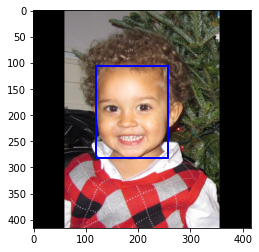

In [8]:
"""
Creates a Pytorch dataset to load the WIDER face dataset
"""
ImageFile.LOAD_TRUNCATED_IMAGES = True


def clamp(n, minn, maxn):
    return max(min(maxn, n), minn)


"""
This function returns a dictionary containing all training samples, for each sample containing the image location ("file_name") and defention of the bounding boxes ("bounding_boxes")
returns: the above discribed dict
"""


def read_data_index(index_path, skip_big_bb=False):
    training_set = []

    f = open(index_path, "r")
    while True:
        file_name = f.readline().strip()

        if not file_name:
            break

        # incl = True #A boolean that tracks whether an image includes ANY large faces, if this bool is set to false the whole image will be skipped
            # (in the case that skip_big_bb = True)
        boxes = []
        isSmall = []
        box_count = int(f.readline())
        if box_count >= 1:
            for i in range(box_count):
                box = f.readline().strip().split(' ')

                treshold = CONFIG.BB_TRESHOLD
                if int(box[2]) < treshold:
                    box = tuple([int(x) for x in box])
                    boxes.append(box)
                elif not skip_big_bb:
                    box = tuple([int(x) for x in box])
                    boxes.append(box)
                # else:
                #    incl = False

        else:
            next(f)

        instance = {
            "file_name": file_name,
            "bounding_boxes": boxes
        }

        training_set.append(instance)

        # if incl:
        #    instance = {
        #        "file_name": file_name,
        #        "bounding_boxes": boxes
        #        }

        #    training_set.append(instance)
        # print("new instance: " + str(instance))

    return training_set


class WIDER_Dataset(Dataset):
    def __init__(
        self,
        index_path,
        image_store_path,
        transform=None,
        max_size=None,
        skip_first=0,
        anchors=CONFIG.ANCHORS,
        image_size=CONFIG.IMAGE_SIZE,
        S=CONFIG.S
    ):
        self.index_path = index_path
        self.image_store_path = image_store_path
        self.data_index = read_data_index(index_path, False)
        self.max_size = max_size
        self.skip_first = skip_first
        self.transform = transform
        self.S = S
        self.anchors = torch.tensor(
            anchors[0] + anchors[1] + anchors[2])  # for all 3 scales
        self.num_anchors = self.anchors.shape[0]
        self.num_anchors_per_scale = self.num_anchors // 3
        self.ignore_iou_thresh = 0.5
        self.DEFAULT_FACE_CLASS = 1
        self.beginIndex = 0
        self.endIndex = 0
        self.shuffledIndexList = list(range(0, CONFIG.numOfIm))
        random.Random(4).shuffle(self.shuffledIndexList)

    def __len__(self):
        # return (len(self.data_index) - self.skip_first if not self.max_size else self.max_size)
        return (self.endIndex - self.beginIndex + 1)

    def setup(self, begin, end):
        # index of the first item that is part of this dataset.
        self.beginIndex = begin
        # index of the last item that is part of this dataset.
        self.endIndex = end

    def __getitem__(self, index):
        index = self.shuffledIndexList[index + self.skip_first + self.beginIndex]
        #  index = index + self.skip_first + self.beginIndex;
        index_item = self.data_index[index]
        bboxes = index_item.get('bounding_boxes')
        img_path = self.image_store_path + index_item.get('file_name')

        image = Image.open(img_path).convert("RGB")
        image = np.array(image)
        image2 = np.array(Image.open(img_path).convert("RGB"))

        # [left, top, width, height, score]
        bboxes = [[bbox[0], bbox[1], bbox[2], bbox[3]] if bbox[2] > 0 and bbox[3] > 0 else
                [bbox[0], bbox[1], bbox[2], 1] if bbox[2] > 0 else
                [bbox[0], bbox[1], 1, bbox[3]] if bbox[3] > 0 else
                [bbox[0], bbox[1], 1, 1] for bbox in bboxes]

        # bboxes = [[bbox[0],bbox[1],bbox[2],bbox[3]] for bbox in bboxes if bbox[2] > 0 and bbox[3] > 0]
        try:
            if self.transform:
                augmentations = self.transform(image=image, bboxes=bboxes)
                image = augmentations["image"]
                bboxes = augmentations["bboxes"]
        except:
            for box in bboxes:
                try:
                    augmentations = self.transform(image=image2, bboxes=[box])
                except Exception as error:
                    print(img_path)
                    print(box)
                    print(error)

        # convert from WIDER X (left) Y (top) width height (absolute) to YOLO X (centre) Y (centre) Width Height (with respect to the image)
        image_width = image.shape[1]
        image_height = image.shape[2]

        bboxes = [[max(0, min((bbox[0] + 0.5 * bbox[2] - 1) / image_width, 1)),
                    max(0, min(
                       (bbox[1] + 0.5 * bbox[3] - 1) / image_height, 1)),
                    min(bbox[2] / image_width, 1),
                    min(bbox[3] / image_height, 1)]
                    for bbox in bboxes]

        targets = UTILS.bboxes_to_cellvectors(
            bboxes, self.anchors, self.S, self.ignore_iou_thresh)

        return image, targets  # , torch.Tensor(bboxes)
        # return image, bboxes

# class WIDER_Dataset(Dataset):
#    def __init__(
#            self,
#            index_path,
#            image_store_path,
#            transform=None,
#            max_size=None,
#            skip_first=0,
#            anchors=CONFIG.ANCHORS,
#            image_size=CONFIG.IMAGE_SIZE,
#            S=CONFIG.S
#    ):
#        self.index_path = index_path
#        self.image_store_path = image_store_path
#        self.data_index = read_data_index(index_path)
#        self.max_size = max_size
#        self.skip_first = skip_first
#        self.transform = transform
#        self.S = S
#        self.anchors = torch.tensor(anchors[0] + anchors[1] + anchors[2])  # for all 3 scales
#        self.num_anchors = self.anchors.shape[0]
#        self.num_anchors_per_scale = self.num_anchors // 3
#        self.ignore_iou_thresh = 0.5
#        self.DEFAULT_FACE_CLASS = 1

#    def __len__(self):
#        return (len(self.data_index) - self.skip_first if not self.max_size else self.max_size)

#    def __getitem__(self, index):

#        index = index + self.skip_first

#        index_item = self.data_index[index]
#        bboxes = index_item.get('bounding_boxes')
#        img_path = self.image_store_path + index_item.get('file_name')

#        image = Image.open(img_path).convert("RGB")
#        image = np.array(image)
#        image2 = np.array(Image.open(img_path).convert("RGB"))

        # [left, top, width, height, score]
#        bboxes = [[bbox[0],bbox[1],bbox[2],bbox[3]] if bbox[2] > 0 and bbox[3] > 0 else
#                  [bbox[0],bbox[1],bbox[2],1] if bbox[2] > 0 else
#                  [bbox[0],bbox[1],1,bbox[3]] if bbox[3] > 0 else
#                  [bbox[0],bbox[1],1,1] for bbox in bboxes]

        # bboxes = [[bbox[0],bbox[1],bbox[2],bbox[3]] for bbox in bboxes if bbox[2] > 0 and bbox[3] > 0]
#        try:
#            if self.transform:
#                augmentations = self.transform(image=image, bboxes=bboxes)
#                image = augmentations["image"]
#                bboxes = augmentations["bboxes"]
#        except:
#            for box in bboxes:
#                try:
#                    augmentations = self.transform(image=image2, bboxes=[box])
#                except Exception as error:
#                    print(img_path)
#                    print(box)
#                    print(error)

        # convert from WIDER X (left) Y (top) width height (absolute) to YOLO X (centre) Y (centre) Width Height (with respect to the image)
#        image_width = image.shape[1]
#        image_height = image.shape[2]

#        bboxes = [[max(0,min((bbox[0] + 0.5 * bbox[2] - 1) / image_width,1)),
#                   max(0,min((bbox[1] + 0.5 * bbox[3] - 1) / image_height,1)),
#                   min(bbox[2] / image_width,1),
#                   min(bbox[3] / image_height,1)]
#                  for bbox in bboxes]

#        targets = UTILS.bboxes_to_cellvectors(bboxes, self.anchors, self.S, self.ignore_iou_thresh)

#        return image, targets#, torch.Tensor(bboxes)
        # return image, bboxes


def test():
    anchors = CONFIG.ANCHORS

    transform = CONFIG.test_transforms

    dataset = WIDER_Dataset(
        CONFIG.INDEX_PATH_ALL,
        '../wider_face/',
        transform=transform
    )

    loader = DataLoader(dataset=dataset, batch_size=1, shuffle=False)
    for x, y in loader:
        print(np.shape(y[0]))

        for vector in y[0][0].view(3*13*13, 5):
            if vector[4] != 0:
                print(vector)

        bboxes_batch = UTILS.cellvectors_to_bboxes(y, anchors)

        bboxes = UTILS.non_max_suppression(
            bboxes_batch[0], iou_threshold=1, threshold=0.7)

        # print(bboxes)

        UTILS.plot_image(x[0].permute(1, 2, 0).to("cpu"), bboxes)

        break


test()


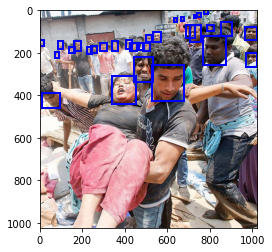

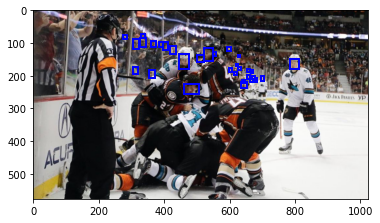

In [6]:
bboxes = [[528, 256, 153, 169, 1],
          [341, 309, 110, 131, 1],
          [444, 220, 88, 118, 1],
          [163, 145, 32, 45, 1],
          [284, 155, 33, 36, 1],
          [770, 122, 109, 136, 1],
          [966, 77, 55, 64, 1],
          [969, 198, 55, 70, 1],
          [338, 144, 29, 45, 1],
          [427, 151, 29, 39, 1],
          [407, 139, 28, 41, 1],
          [222, 170, 22, 34, 1],
          [240, 167, 31, 33, 1],
          [0, 138, 18, 30, 2],
          [86, 146, 24, 35, 1],
          [138, 172, 26, 27, 1],
          [487, 155, 32, 35, 1],
          [468, 153, 21, 34, 1],
          [499, 117, 28, 32, 2],
          [535, 101, 35, 47, 1],
          [708, 69, 53, 78, 1],
          [687, 69, 44, 59, 1],
          [788, 69, 31, 30, 2],
          [633, 35, 15, 21, 2],
          [663, 31, 14, 18, 2],
          [724, 22, 12, 13, 2],
          [741, 14, 16, 15, 2],
          # not visible and x bigger than image size (1024)
          [1050, 142, 0, 50, 2],
          [771, 0, 19, 15, 2],
          [70, 195, 22, 30, 2],
          [852, 52, 52, 68, 1],
          [10, 388, 87, 71, 1]]

img_path = "../wider_face/train/54--Rescue/54_Rescue_rescuepeople_54_29.jpg"
image = np.array(Image.open(img_path).convert("RGB"))
UTILS.plot_image(image, bboxes, yolo=False)

bboxes = [[784, 148, 27, 33, 2],
          [696, 202, 10, 13, 2],
          [304, 88, 20, 29, 2],
          [352, 183, 20, 25, 2],
          [445, 134, 32, 46, 1],
          [460, 224, 45, 33, 1],
          [395, 97, 16, 25, 2],
          # not visible and x bigger than image size (1024)
          [1026, 474, 0, 23, 2],
          [384, 97, 11, 15, 2],
          [521, 114, 27, 40, 2],
          [499, 137, 21, 22, 2],
          [325, 86, 18, 25, 2],
          [303, 173, 17, 22, 2],
          [274, 74, 13, 13, 2],
          [329, 72, 13, 13, 2],
          [652, 198, 10, 11, 2],
          [661, 210, 10, 9, 2],
          [676, 206, 9, 13, 2],
          [668, 201, 8, 10, 2],
          [599, 177, 9, 12, 2],
          [627, 173, 9, 11, 2],
          [626, 137, 5, 7, 2],
          [619, 164, 5, 6, 2],
          [639, 212, 7, 9, 2],
          [418, 108, 19, 25, 2],
          [359, 94, 16, 17, 2],
          [612, 188, 10, 11, 2],
          [653, 178, 10, 11, 2],
          [634, 220, 20, 17, 2],
          [550, 127, 9, 12, 2],
          [593, 112, 12, 13, 2],
          [665, 182, 6, 11, 2]]

img_path = "../wider_face/validation/39--Ice_Skating/39_Ice_Skating_iceskiing_39_583.jpg"
image = np.array(Image.open(img_path).convert("RGB"))
UTILS.plot_image(image, bboxes, yolo=False)


# Loss function

In [16]:
"""
Implementation of Yolo Loss Function similar to the one in Yolov3 paper,
the difference from what I can tell is I use CrossEntropy for the classes
instead of BinaryCrossEntropy.
"""

class YoloLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        # self.bce = nn.BCEWithLogitsLoss()
        self.bce = nn.BCELoss()

        # Constants signifying how much to pay for each respective part of the loss
        self.lambda_noobj = 10
        self.lambda_obj = 1
        self.lambda_box = 10

        # self.lambda_noobj = 15
        # self.lambda_obj = 2
        # self.lambda_box = 35

    def weighted_mse_loss(self, input, target, weight):
        return torch.sum(weight * (input - target) ** 2)

    def obj_present(self, target):
        return target[..., 4] == 1

    def get_box_predictions(self, bbox_list):
        return bbox_list[...,0:4]

    def get_obj_predictions(self, bbox_list):
        return bbox_list[...,4]

    def get_no_object_loss(self, target, prediction, obj_present):

        obj_not_present = torch.logical_not(obj_present)

        target_object_score = self.get_obj_predictions(target[obj_not_present])
        prediction_object_score = self.get_obj_predictions(prediction[obj_not_present])

        return self.bce(prediction_object_score, target_object_score)

    def get_object_loss_simplified(self, target, prediction, object_present):

        target_object_score = self.get_obj_predictions(target[object_present])
        prediction_oject_score = self.get_obj_predictions(prediction[object_present])

        object_loss = self.bce(prediction_oject_score, target_object_score)
        return object_loss

    def get_object_loss(self, target, prediction, object_present):

        #take the scale for later
        scale = 1 / target.shape[2]
        
        #select only the boxes of interest (where there are supposed to be boxes)
        target = target[object_present]
        prediction = prediction[object_present]
        
        #scale the x and y position according to the scale to be able to calculate IOU (no need to add the actual grid position here because for the IOU only the relative distance is important)
        #rescaling is needed because in the output vector of the model x and y are relative to the grid cell, while with and height are relative to the hole image. These have to be in the same shape to be able to calculate IOU
        target[...,0:2] = target[...,0:2] * scale
        prediction[...,0:2] = prediction[...,0:2] * scale

        target_object_score = self.get_obj_predictions(target)
        prediction_oject_score = self.get_obj_predictions(prediction)

        #calculate the IOU of the boxes 
        ious = UTILS.intersection_over_union(self.get_box_predictions(target), self.get_box_predictions(prediction.detach()))
        ious = torch.diagonal(ious)
        
        #if there is an object, the object score should be equal to the IOU of the predicting box and the true box
        object_loss = self.bce(prediction_oject_score, ious * target_object_score)

        return object_loss

        # return self.bce(target_object_score, prediction_oject_score)
        # return self.mse(target_object_score, prediction_object_score)

    def get_box_loss(self, target, prediction, object_present):
        target_box = self.get_box_predictions(target[object_present])
        predicted_box = self.get_box_predictions(prediction[object_present])

        target_box[...,2:4] = torch.log(1e-16 + target_box[...,2:4])
        predicted_box[...,2:4] = torch.log(1e-16 + predicted_box[...,2:4])

        return self.mse(predicted_box, target_box)


    def forward(self, predictions, target):
        # FORMAT: (x, y, w, h, obj)

        object_present = self.obj_present(target)

        return (
            self.lambda_box * self.get_box_loss(target, predictions, object_present)
            + self.lambda_obj * self.get_object_loss(target, predictions, object_present)
            # + self.lambda_obj * self.get_object_loss_simplified(target, predictions, object_present)
            + self.lambda_noobj * self.get_no_object_loss(target, predictions, object_present)
        )

"""
This is the implementation of our custom desined loss function 
"""
class RescaledPositionalLoss(YoloLoss):

    def __init__(self):
        super().__init__()
        self.lambda_pos = 0.01
        self.lambda_size = 1
        
        self.lambda_noobj = 10
        self.lambda_obj = 1
        self.lambda_box = 2

    def get_box_loss(self, target, prediction, object_present):
        target_box = self.get_box_predictions(target[object_present])
        predicted_box = self.get_box_predictions(prediction[object_present])

        #the weights are equal to the reciproke of the dimensions of the box (linear)
        weights = 1/target_box[...,2:4].detach()

        target_box[...,2:4] = torch.log(1e-16 + target_box[...,2:4])
        predicted_box[...,2:4] = torch.log(1e-16 + predicted_box[...,2:4])

        size_loss = self.mse(predicted_box[...,2:4], target_box[...,2:4])

        position_loss_x =  self.weighted_mse_loss(predicted_box[...,0], target_box[...,0], weights[...,0])
        position_loss_y =  self.weighted_mse_loss(predicted_box[...,1], target_box[...,1], weights[...,1])

        return self.lambda_pos * (position_loss_x + position_loss_y) + self.lambda_size * size_loss

class GeneralizedIOULoss(YoloLoss):
    def __init__(self):
        super().__init__()
        self.lambda_noobj = 10
        self.lambda_obj = 1
        self.lambda_box = 1


    def get_box_loss(self, target, prediction, object_present):

        S = target.shape[-2]
        print(f"S: {S}")
        #last dimension: [cx,cy,w,h]
        target_box = self.get_box_predictions(target[object_present])
        predicted_box = self.get_box_predictions(prediction[object_present])

        # print(f"target_box: {target_box}")
        # print(f"predicted_box: {predicted_box}")

        #step 1 of algorithm 2 from https://tinyurl.com/giouloss is not needed, since our format of [cx,cy,w,h] with positive w and h (sigmoid) ensures that x2 > x1 and y2 > y1

        #step 2 and 3 of algorithm 2 from https://tinyurl.com/giouloss calculating area of target boxes, in our case this is simply w x h
        a_target = target_box[...,2] * target_box[...,3]
        a_pred = predicted_box[...,2] * predicted_box[...,3]

        #step 4 requires other box format, doing it manually here to ensure gradient flow. new box format: [x1, x2, y1. y2]
        target_box_xxyy = torch.zeros(target_box.shape).to(CONFIG.DEVICE)
        target_box_xxyy[...,0] = target_box[...,0] - 0.5 * target_box[...,2] #x1 = cx - 0.5 * w
        target_box_xxyy[...,1] = target_box[...,0] + 0.5 * target_box[...,2] #x2 = cx + 0.5 * w
        target_box_xxyy[...,2] = target_box[...,1] - 0.5 * target_box[...,3] #y1 = cy - 0.5 * h
        target_box_xxyy[...,3] = target_box[...,1] + 0.5 * target_box[...,3] #y2 = cy + 0.5 * h

        predicted_box_xxyy = torch.zeros(predicted_box.shape).to(CONFIG.DEVICE)
        predicted_box_xxyy[...,0] = predicted_box[...,0] - 0.5 * predicted_box[...,2] #x1 = cx - 0.5 * w
        predicted_box_xxyy[...,1] = predicted_box[...,0] + 0.5 * predicted_box[...,2] #x2 = cx + 0.5 * w
        predicted_box_xxyy[...,2] = predicted_box[...,1] - 0.5 * predicted_box[...,3] #y1 = cy - 0.5 * h
        predicted_box_xxyy[...,3] = predicted_box[...,1] + 0.5 * predicted_box[...,3] #y2 = cy + 0.5 * h

        #step 4 of algorithm 2 from https://tinyurl.com/giouloss, calculating the intersection between the boxes
        xi1 = torch.max(predicted_box_xxyy[...,0], target_box_xxyy[...,0])
        xi2 = torch.min(predicted_box_xxyy[...,1], target_box_xxyy[...,1])
        yi1 = torch.max(predicted_box_xxyy[...,2], target_box_xxyy[...,2])
        yi2 = torch.min(predicted_box_xxyy[...,3], target_box_xxyy[...,3])

        assert xi1.shape == xi2.shape == yi1.shape == yi2.shape
        condition = torch.logical_and(xi2 > xi1, yi2 > yi1)
        intersection = torch.zeros(xi1.shape).to(CONFIG.DEVICE)
        intersection = (xi2 - xi1) * (yi2 - yi1)
        intersection = intersection * condition
        union = a_target + a_pred - intersection
        
        #step 5 of algorithm 2 from https://tinyurl.com/giouloss, calculating the enclosing box
        xc1 = torch.min(predicted_box_xxyy[...,0], target_box_xxyy[...,0])
        xc2 = torch.max(predicted_box_xxyy[...,1], target_box_xxyy[...,1])
        yc1 = torch.min(predicted_box_xxyy[...,2], target_box_xxyy[...,2])
        yc2 = torch.max(predicted_box_xxyy[...,3], target_box_xxyy[...,3])

        #step 6 of algorithm 2 from https://tinyurl.com/giouloss, calculating the enclosing box area
        area_enclosing_box = (xc2 - xc1) * (yc2 -yc1)
        # print(f"area enclosing: {area_enclosing_box}")
        # print(f"enclosing: {area_enclosing_box}")

        #step 7 of algorithm 2 from https://tinyurl.com/giouloss, calculating the normal iou
        iou = intersection / union
        # print(f"iou: {iou}")

        #step 8 of algorithm 2 from https://tinyurl.com/giouloss, calculating the giou
        giou = iou - ((area_enclosing_box - union) / area_enclosing_box)
        # print(giou)

        #step 9 of algorithm 2 from https://tinyurl.com/giouloss, calculating the final box loss (and converting it to one scaler for our application)
        losses = torch.ones(giou.shape).to(CONFIG.DEVICE)
        losses = losses - giou

        return torch.mean(losses)

class DistanceIOULoss(YoloLoss):
    def __init__(self):
        super().__init__()
        self.lambda_noobj = 10
        self.lambda_obj = 1
        self.lambda_box = 1


    def get_box_loss(self, target, prediction, object_present):
        #last dimension: [cx,cy,w,h]
        target_box = self.get_box_predictions(target[object_present])
        predicted_box = self.get_box_predictions(prediction[object_present])

        #first convert to x1,x2,y1,y2 format
        xt1 = target_box[...,0] - (0.5 * target_box[...,2]) 
        xt2 = target_box[...,0] + (0.5 * target_box[...,2]) 
        yt1 = target_box[...,1] - (0.5 * target_box[...,3]) 
        yt2 = target_box[...,1] + (0.5 * target_box[...,3]) 
        
        xp1 = predicted_box[...,0] - (0.5 * predicted_box[...,2]) 
        xp2 = predicted_box[...,0] + (0.5 * predicted_box[...,2]) 
        yp1 = predicted_box[...,1] - (0.5 * predicted_box[...,3]) 
        yp2 = predicted_box[...,1] + (0.5 * predicted_box[...,3]) 

        #calculating intersection
        xi1 = torch.max(xt1, xp1)
        xi2 = torch.min(xt2, xp2)
        yi1 = torch.max(yt1, yp1)
        yi2 = torch.min(yt2, yp2)

        intersection = torch.zeros(xi1.shape).to(CONFIG.DEVICE)
        mask = (xi1 < xi2) * (yi1 < yi2)
        intersection[mask] = (xi2[mask] - xi1[mask]) * (yi2[mask] - yi1[mask]) 
        # print(f"intersection: {intersection}")
        union = (xt2 - xt1)  * (yt2 - yt1) + (xp2 - xp1)  * (yp2 - yp1) - intersection
        # print(f"union: {union}")
        iou = intersection / union
        # print(f"iou: {iou}"

        #calculating enclosing box
        xc1 = torch.min(xt1, xp1)
        xc2 = torch.max(xt2, xp2)
        yc1 = torch.min(yt1, yp1)
        yc2 = torch.max(yt2, yp2)

        enclosing_box_area = (xc2 - xc1) * (yc2 - yc1) 

        # print(f"enclosing: {enclosing_box_area}")

        #distance part
        Rdiou = torch.square(target_box[...,0] - predicted_box[...,0]) + torch.square(target_box[...,1] - predicted_box[...,1]) / (torch.square(enclosing_box_area) + 1e-7)

        # print(f"enclosing: {enclosing_box_area}")

        # print(f"distance: {distance}")

        # print(torch.mean(distance))

        # print(torch.mean(iou))

        loss = torch.tensor([1]).to(CONFIG.DEVICE) - 0.1* torch.mean(iou) + torch.mean(Rdiou)

        return loss

# class DirectLoss(YoloLoss):

#     def __init__(self):
#         super().__init__()

#     def get_box_loss(self, target, prediction, object_present):
#         target_box = self.get_box_predictions(target[object_present])
#         predicted_box = self.get_box_predictions(prediction[object_present])

#         # The weights are equal to the reciprocal of the dimensions of the box (linear)
#         weights = 1/target_box[...,2:4].detach()

#         target_box[...,2:4] = torch.log(1e-16 + target_box[...,2:4])
#         predicted_box[...,2:4] = torch.log(1e-16 + predicted_box[...,2:4])

#         loss = torch.sum(UTILS.distance_intersection_over_union_loss(predicted_box, target_box))
#         return loss

# class CompleteLoss(YoloLoss):

#     def __init__(self):
#         super().__init__()

#     def get_box_loss(self, target, prediction, object_present):

#         target_box = self.get_box_predictions(target[object_present])  # Gecheckt
#         predicted_box = self.get_box_predictions(prediction[object_present])  # Gecheckt
#         # The weights are equal to the reciprocal of the dimensions of the box (linear)
#         weights = 1/target_box[...,2:4].detach()
        
#         target_box[...,2:4] = torch.log(1e-16 + target_box[...,2:4])
#         predicted_box[...,2:4] = torch.log(1e-16 + predicted_box[...,2:4])
        
#         loss = torch.sum(UTILS.complete_intersection_over_union_loss(predicted_box, target_box))
#         return loss

# class GeneralLoss(YoloLoss):

#     def __init__(self):
#         super().__init__()

#     def get_box_loss(self, target, prediction, object_present):
#         target_box = self.get_box_predictions(target[object_present])
#         predicted_box = self.get_box_predictions(prediction[object_present])

#         # The weights are equal to the reciprocal of the dimensions of the box (linear)
#         weights = 1/target_box[...,2:4].detach()

#         target_box[...,2:4] = torch.log(1e-16 + target_box[...,2:4])
#         predicted_box[...,2:4] = torch.log(1e-16 + predicted_box[...,2:4])

#         loss = torch.sum(UTILS.generalised_intersection_over_union_loss(predicted_box, target_box))
#         return loss

In [10]:
class TestLossFunction(unittest.TestCase):
    
    def generate_empty_example(self):
        batch_size = 1
        S = 3
        anchors_per_scale = 3

        target = torch.zeros(batch_size, anchors_per_scale, S, S, 5)
        predictions = torch.zeros(batch_size, anchors_per_scale, S, S, 5)

        return target, predictions

    def setUp(self):
        self.lossfn = YoloLoss()
        self.rescaledpositionallossfn = RescaledPositionalLoss()
        self.giou_loss = GeneralizedIOULoss()
        self.diou_loss = DistanceIOULoss()

    def test_no_object_loss(self):
        target, predictions = self.generate_empty_example()

        #correct object score, loss = 0
        target[0,0,0,0] = torch.Tensor([0.5, 0.5, 0.2, 0.2, 0])
        predictions[0,0,0,0] = torch.Tensor([0.5, 0.5, 0.2, 0.2, 0])

        #incorrect object score, but should be ignored because there is an object loss = 0
        target[0,0,0,1] = torch.Tensor([0.5, 0.5, 0.2, 0.2, 1])
        predictions[0,0,0,1] = torch.Tensor([0.5, 0.5, 0.2, 0.2, 0.5])

         #wrong_box_score, loss = -1 * (yn log(xn) + (1-yn)log(1-xn)) = 
        target[0,0,1,1] = torch.Tensor([0.5, 0.5, 0.2, 0.2, 0])
        predictions[0,0,1,1] = torch.Tensor([0, 0.5, 0.2, 0.2, 0.5])
        
        # #wrong_box_score, loss = -1 * (yn log(xn) + (1-yn) log(1-xn)) = -1 * (0 * log(0) + 1 * log(1)) = -1 * log(1)
        #  #bce function sees log(0) as -100
        target[0,0,1,0] = torch.Tensor([0.5, 0.5, 0.2, 0.2, 0])
        predictions[0,0,1,0] = torch.Tensor([0, 0.5, 0.2, 0.2, 1])

        object_present = self.lossfn.obj_present(target)
        no_object_loss = self.lossfn.get_no_object_loss(target, predictions, object_present)

        manual_loss = -1 * (1 * math.log(1-0.5) + 1 * -100)/ (3 * 3 * 3 - 1)

        self.assertTrue(abs(manual_loss - no_object_loss.item()) < 1e-5)

    def test_object_loss(self):
        target, predictions = self.generate_empty_example()

        #correct object score, IOU = 1, loss = 0
        target[0,0,0,0] = torch.Tensor([0.5, 0.5, 0.2, 0.2, 1])
        predictions[0,0,0,0] = torch.Tensor([0.5, 0.5, 0.2, 0.2, 1])

        #wrong object score, IOU = 0.5, loss = -1 (0.5log(1) + 0.5 * -100)
        target[0,0,0,1] = torch.Tensor([0.1, 0.1, 0.2, 0.2, 1])
        predictions[0,0,0,1] = torch.Tensor([0.1, 0.1, 0.1, 0.2, 1])

        # #wrong object score, but should be ignored
        target[0,0,1,0] = torch.Tensor([0.5, 0.5, 0.2, 0.2, 0])
        predictions[0,0,1,0] = torch.Tensor([0.5, 0.5, 0.1, 0.2, 1])

        # #wrong object score, IOU = 0.25, loss = -1 (0.25log(0.5) + 0.75log(0.5))
        target[0,0,1,1] = torch.Tensor([0.9, 0.9, 0.2, 0.2, 1])
        predictions[0,0,1,1] = torch.Tensor([0.9, 0.9, 0.2, 0.05, 0.5])

        object_present = self.lossfn.obj_present(target)
        object_loss = self.lossfn.get_object_loss(target, predictions, object_present)

        manual_loss =(-1 * (0.5 * math.log(1) + 0.5 * -100) + -1 * (0.25 * math.log(0.5) + 0.75 * math.log(0.5)))/ 3
        
        self.assertTrue(abs(manual_loss - object_loss.item()) < 1e-5)

    def test_box_loss(self):
        target, predictions = self.generate_empty_example()

        #correct_box_score, loss = 0
        target[0,0,0,0] = torch.Tensor([0.5, 0.5, 0.2, 0.2, 1])
        predictions[0,0,0,0] = torch.Tensor([0.5, 0.5, 0.2, 0.2, 0])

        #wrong_box_score, loss = 0.5^2/4 = 0.0625
        target[0,0,0,1] = torch.Tensor([0.5, 0.5, 0.2, 0.2, 1])
        predictions[0,0,0,1] = torch.Tensor([0, 0.5, 0.2, 0.2, 0])

        #wrong_box_score, loss = 0.5^2/4 = 0.0625
        target[0,0,1,1] = torch.Tensor([0.5, 0.5, 0.2, 0.2, 1])
        predictions[0,0,1,1] = torch.Tensor([0, 0.5, 0.2, 0.2, 0])

        #wrong_box_score, but should be ignored. loss = 0
        target[0,0,0,2] = torch.Tensor([0.5, 0.5, 0.2, 0.2, 0])
        predictions[0,0,0,2] = torch.Tensor([0, 0.5, 0.2, 0.2, 0])

        #wrong_box_score, loss = (log(0.2)-log(0.02))^2 * 2 / 4
        target[0,0,1,2] = torch.Tensor([0.5, 0.5, 0.2, 0.2, 1])
        predictions[0,0,1,2] = torch.Tensor([0.5, 0.5, 0.02, 0.02, 1])

        object_present = self.lossfn.obj_present(target)
        box_loss = self.lossfn.get_box_loss(target, predictions, object_present)

        #mean loss = 0.0625 + 0.0625 / 3 = 0.625
        manual_loss = (0.0625 + 0.0625 + (math.log(0.2) - math.log(0.02))**2 * 2 / 4) / 4

        self.assertTrue(abs(box_loss.item() - manual_loss) < 0.0001)

    def test_rescaled_positional_loss(self):
        target, predictions = self.generate_empty_example()

        target[0,0,0,0] = torch.Tensor([0.2, 0.2, 0.2, 0.2, 1])
        predictions[0,0,0,0] = torch.Tensor([0.3, 0.3, 0.2, 0.2, 1])

        target[0,0,0,1] = torch.Tensor([0.5, 0.5, 0.02, 0.02, 1])
        predictions[0,0,0,1] = torch.Tensor([0.1, 0.1, 0.02, 0.02, 1])

        object_present = self.lossfn.obj_present(target)
        loss1 = self.rescaledpositionallossfn.get_box_loss(target, predictions, object_present)

        target, predictions = self.generate_empty_example()

        target[0,0,0,0] = torch.Tensor([0.2, 0.2, 0.1, 0.1, 1])
        predictions[0,0,0,0] = torch.Tensor([0.3, 0.3, 0.1, 0.1, 1])

        target[0,0,0,1] = torch.Tensor([0.5, 0.5, 0.01, 0.01, 1])
        predictions[0,0,0,1] = torch.Tensor([0.1, 0.1, 0.01, 0.01, 1])

        object_present = self.lossfn.obj_present(target)
        loss2 = self.rescaledpositionallossfn.get_box_loss(target, predictions, object_present)

        self.assertEqual(loss1.item() * 2, loss2.item())

    def test_generalized_iou_loss(self):
        target, predictions = self.generate_empty_example()

        target[0,0,0,0] = torch.Tensor([0.1, 0.2, 0.2, 0.2, 1])
        predictions[0,0,0,0] = torch.Tensor([0.8, 0.8, 0.1, 0.1, 1])

        # target[0,0,0,1] = torch.Tensor([0.205, 0.2, 0.001, 0.02, 1])
        # predictions[0,0,0,1] = torch.Tensor([0.1, 0.1, 1, 0.5, 1])

        object_present = self.lossfn.obj_present(target)
        loss1 = self.giou_loss.get_box_loss(target, predictions, object_present)

        # print(loss1)

        self.assertEqual(0,0)

    def test_distance_iou_loss(self):
        target, predictions = self.generate_empty_example()

        target[0,0,0,0] = torch.Tensor([0.8, 0.8, 0.1, 0.1, 1])
        predictions[0,0,0,0] = torch.Tensor([0.81, 0.8, 0.1, 0.1, 1])

        # target[0,0,0,1] = torch.Tensor([0.1, 0.2, 0.1, 0.1, 1])
        # predictions[0,0,0,1] = torch.Tensor([0.1, 0.1, 0.1, 0.1, 1])

        object_present = self.diou_loss.obj_present(target)
        loss1 = self.diou_loss.get_box_loss(target, predictions, object_present)

        print(f"loss: {loss1}")

        self.assertEqual(0,0)

unittest.main(argv=['first-arg-is-ignored'], exit=False)


.EE.................
ERROR: test_distance_iou_loss (__main__.TestLossFunction)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-10-a74e9111bde0>", line 154, in test_distance_iou_loss
    loss1 = self.diou_loss.get_box_loss(target, predictions, object_present)
  File "<ipython-input-9-4dd74b1b9bf8>", line 241, in get_box_loss
    intersection[mask] = (xi2[mask] - xi1[mask]) * (yi2[mask] - yi1[mask])
RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

ERROR: test_generalized_iou_loss (__main__.TestLossFunction)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-10-a74e9111bde0>", line 138, in test_generalized_iou_loss
    loss1 = self.giou_loss.get_box_loss(target, predictions, object_present)
  File "<ipython-input-9-4dd74b1b9bf8>", line 182, in get_box_loss
    union = a_ta

# Testing IOU

In [9]:
# train_loader, test_loader, train_loader_evaluation, evaluation_loader = UTILS.get_loaders()
# x, y = iter(train_loader_evaluation).next()
# bboxes_batch = UTILS.cellvectors_to_bboxes(y, CONFIG.ANCHORS)
# bboxes = UTILS.non_max_suppression(
#     bboxes_batch[0], iou_threshold=1, threshold=0.7)
# # print(bboxes_batch)
# bboxes[1][3] = bboxes[1][3]/2
# bboxes[2][2] = bboxes[2][2]/2
# bboxes[2][3] = bboxes[2][3]/2
# bboxes.append(copy.copy(bboxes[2]))
# bboxes[3][0] = 0

# # print(bboxes)

# UTILS.plot_image(x[0].permute(1, 2, 0).to("cpu"), bboxes)

# reference = torch.Tensor([bboxes[0][0:4]])
# bboxes_tensor = torch.Tensor([box[0:4] for box in bboxes])
# print(reference)
# print(bboxes_tensor)

# print(UTILS.intersection_over_union(reference, bboxes_tensor, "cxcywh"))
# print(UTILS.intersection_over_union(reference, bboxes_tensor, "xywh"))


# Database Test

In [10]:
#test for db split code:

#train_dataset = WIDER_Dataset(
#    CONFIG.INDEX_PATH_TRAIN, 
#    CONFIG.IMAGE_STORE_PATH_TRAIN, 
#    transform=CONFIG.test_transforms
#)
#train_dataset.setup(0, 5)
        
#train_loader = DataLoader(
#    dataset=train_dataset,
#    batch_size=CONFIG.BATCH_SIZE,
#    num_workers=CONFIG.NUM_WORKERS,
#    pin_memory=CONFIG.PIN_MEMORY,
#    shuffle=True,
#    drop_last=False,
#)

#img, label = train_dataset[0]
#length = train_dataset.__len__()
#print(length)

#print (img)

#UTILS.plot_image(img.permute(1, 2, 0).to("cpu"), label)

#trainSplit, valSplit, testSplit = CONFIG.dataSplit
#total = CONFIG.numOfIm

#trainStart = 0
#trainEnd = int(total*trainSplit) -1

#valStart = trainEnd+1
#valEnd = int(valStart+(total*valSplit)) -1

#testStart = valEnd+1
#testEnd = int(testStart+(total*testSplit))

#print(total)

#print(trainStart)
#print(trainEnd)
#print(valStart)
#print(valEnd)
#print(testStart)
#print(testEnd)


#UTILS.plot_image(img.permute(1, 2, 0).to("cpu"), label)

# Overfitting test

In [17]:
# CUDA_LAUNCH_BLOCKING=1
# CONFIG.DEVICE = 'cpu'
model = YOLOv3().to(CONFIG.DEVICE)


  0%|          | 0/51 [00:00<?, ?it/s]

S: 13
S: 26
S: 52


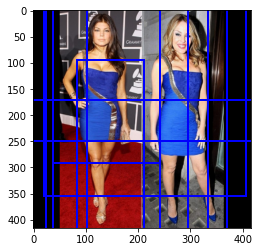

  2%|▏         | 1/51 [00:00<00:32,  1.55it/s]

predicted boxvectors:
tensor([[0.4193, 0.4993, 5.1805, 4.2401, 0.5115],
        [0.4906, 0.6934, 4.1111, 3.6840, 0.5384]], grad_fn=<IndexBackward>)
target boxvectors:
tensor([[0.0412, 0.3517, 0.0918, 0.1115, 1.0000],
        [0.8411, 0.6140, 0.0882, 0.1445, 1.0000]])
Loss: 25.857830047607422
mAP: 0.0


  4%|▍         | 2/51 [00:00<00:17,  2.74it/s]

S: 13
S: 26
S: 52


  6%|▌         | 3/51 [00:01<00:14,  3.20it/s]

S: 13
S: 26
S: 52


  8%|▊         | 4/51 [00:01<00:13,  3.54it/s]

S: 13
S: 26
S: 52


 10%|▉         | 5/51 [00:01<00:12,  3.71it/s]

S: 13
S: 26
S: 52


 12%|█▏        | 6/51 [00:01<00:11,  3.89it/s]

S: 13
S: 26
S: 52


 14%|█▎        | 7/51 [00:02<00:11,  3.99it/s]

S: 13
S: 26
S: 52


 16%|█▌        | 8/51 [00:02<00:10,  4.08it/s]

S: 13
S: 26
S: 52


 18%|█▊        | 9/51 [00:02<00:10,  4.16it/s]

S: 13
S: 26
S: 52


 20%|█▉        | 10/51 [00:02<00:09,  4.17it/s]

S: 13
S: 26
S: 52
S: 13
S: 26
S: 52


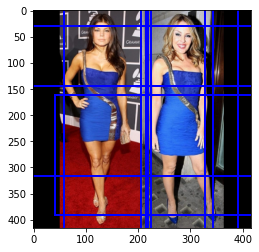

 22%|██▏       | 11/51 [00:03<00:13,  2.90it/s]

predicted boxvectors:
tensor([[0.4197, 0.5085, 1.1944, 0.6507, 0.0256],
        [0.4200, 0.5086, 1.1936, 0.6493, 0.0256]], grad_fn=<IndexBackward>)
target boxvectors:
tensor([[0.0412, 0.3517, 0.0918, 0.1115, 1.0000],
        [0.8411, 0.6140, 0.0882, 0.1445, 1.0000]])
Loss: 7.559268951416016
mAP: 0.0


 24%|██▎       | 12/51 [00:03<00:11,  3.45it/s]

S: 13
S: 26
S: 52


 25%|██▌       | 13/51 [00:03<00:10,  3.66it/s]

S: 13
S: 26
S: 52


 27%|██▋       | 14/51 [00:03<00:10,  3.68it/s]

S: 13
S: 26
S: 52


 29%|██▉       | 15/51 [00:04<00:09,  3.81it/s]

S: 13
S: 26
S: 52


 31%|███▏      | 16/51 [00:04<00:09,  3.88it/s]

S: 13
S: 26
S: 52


 33%|███▎      | 17/51 [00:04<00:08,  3.99it/s]

S: 13
S: 26
S: 52


 35%|███▌      | 18/51 [00:04<00:08,  4.05it/s]

S: 13
S: 26
S: 52


 37%|███▋      | 19/51 [00:05<00:07,  4.05it/s]

S: 13
S: 26
S: 52


 39%|███▉      | 20/51 [00:05<00:07,  4.02it/s]

S: 13
S: 26
S: 52
S: 13
S: 26
S: 52


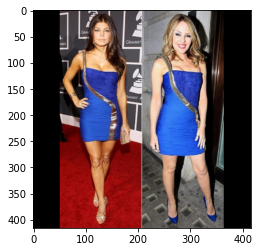

predicted boxvectors:
tensor([[0.1665, 0.4234, 2.3844, 1.9146, 0.0074],
        [0.1707, 0.4251, 2.3552, 1.8681, 0.0075]], grad_fn=<IndexBackward>)
target boxvectors:
tensor([[0.0412, 0.3517, 0.0918, 0.1115, 1.0000],
        [0.8411, 0.6140, 0.0882, 0.1445, 1.0000]])
Loss: 4.589367389678955


 43%|████▎     | 22/51 [00:06<00:09,  3.16it/s]

mAP: 0.0
S: 13
S: 26
S: 52


 45%|████▌     | 23/51 [00:06<00:08,  3.42it/s]

S: 13
S: 26
S: 52


 47%|████▋     | 24/51 [00:06<00:07,  3.59it/s]

S: 13
S: 26
S: 52


 49%|████▉     | 25/51 [00:07<00:07,  3.70it/s]

S: 13
S: 26
S: 52


 51%|█████     | 26/51 [00:07<00:06,  3.75it/s]

S: 13
S: 26
S: 52


 53%|█████▎    | 27/51 [00:07<00:06,  3.83it/s]

S: 13
S: 26
S: 52


 55%|█████▍    | 28/51 [00:07<00:05,  3.85it/s]

S: 13
S: 26
S: 52


 57%|█████▋    | 29/51 [00:08<00:05,  3.84it/s]

S: 13
S: 26
S: 52


 59%|█████▉    | 30/51 [00:08<00:05,  3.85it/s]

S: 13
S: 26
S: 52
S: 13
S: 26
S: 52


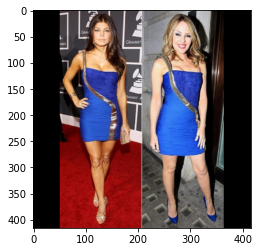

 61%|██████    | 31/51 [00:08<00:07,  2.62it/s]

predicted boxvectors:
tensor([[9.2205e-02, 4.1198e-01, 1.9653e+00, 3.8619e+00, 2.1083e-03],
        [1.0285e-01, 4.1671e-01, 1.9174e+00, 3.4867e+00, 2.3082e-03]],
       grad_fn=<IndexBackward>)
target boxvectors:
tensor([[0.0412, 0.3517, 0.0918, 0.1115, 1.0000],
        [0.8411, 0.6140, 0.0882, 0.1445, 1.0000]])
Loss: 3.817411184310913
mAP: 0.0


 63%|██████▎   | 32/51 [00:09<00:06,  3.07it/s]

S: 13
S: 26
S: 52


 65%|██████▍   | 33/51 [00:09<00:05,  3.24it/s]

S: 13
S: 26
S: 52


 67%|██████▋   | 34/51 [00:09<00:05,  3.27it/s]

S: 13
S: 26
S: 52


 67%|██████▋   | 34/51 [00:09<00:04,  3.41it/s]


KeyboardInterrupt: 

In [18]:
import torch
import torch.optim as optim

from tqdm import tqdm

import warnings
from IPython.display import clear_output
from sklearn.model_selection import KFold

test_lr = 1e-3
anchors = CONFIG.ANCHORS

# REMOVE

def train_model(model, loader, epochs):


    optimizer = optim.Adam(
        model.parameters(), lr=test_lr, weight_decay=0
    )

    loss_fn = GeneralizedIOULoss()

    for epoch in tqdm(range(epochs)):
        for i, (x, y) in enumerate(loader):
            x = x.to(CONFIG.DEVICE)

            model.train()

            optimizer.zero_grad()

            out = model(x)

            out_cpu = [output.to("cpu") for output in out]

            loss =  loss_fn(out[0], y[0].to(CONFIG.DEVICE))\
                    + loss_fn(out[1], y[1].to(CONFIG.DEVICE))\
                    + loss_fn(out[2], y[2].to(CONFIG.DEVICE))

            loss.backward()

            optimizer.step()

            if epoch % 10 == 0:

                bboxes_batch = UTILS.cellvectors_to_bboxes(out_cpu, CONFIG.ANCHORS)

                for i in range(len(x)):

                    bboxes = UTILS.non_max_suppression(bboxes_batch[i], threshold=CONFIG.NMS_IOU_THRESH)
                    UTILS.plot_image(x[i].permute(1, 2, 0).to("cpu"), bboxes)

                    print("predicted boxvectors:")
                    print(out_cpu[0][i][loss_fn.obj_present(y[0][i])])
                    print("target boxvectors:")
                    print(y[0][i][loss_fn.obj_present(y[0][i])])

                    print("Loss: {}".format(loss))

                mean_ap = UTILS.evaluate_model(loader, model)
                print("mAP: {}".format(mean_ap))

train_loader, test_loader, train_loader_evaluation, _ = UTILS.get_loaders()
        
train_model(model, train_loader_evaluation, 51)

# Train Method

In [26]:
# If had a previous run, you can set a number of previous epochs when loadnig from a checkpoint
def train_model(model, loss_fn, optimizer, train_loader, test_loader,
                epochs=CONFIG.NUM_EPOCHS, load_checkpoint = CONFIG.LOAD_CHECKPOINT, save_model = CONFIG.SAVE_MODEL, save_results = CONFIG.SAVE_RESULTS,
                verbose = False, show_examples = False, early_stop = False, stop_plateau = False, loss_margin = 0.001):
    """Main training method for training the YOLO model. Options are availabel for saving and loading checkpoints during training,
    saving training progress results in the form of MAP to an external file and finally the option to automatically stop training 
    when the loss reaches a plateau.

    Args:
        model (torch.nn.Module): The model to be trained
        loss_fn ([type]): The loss to be used during training
        optimizer (torch.optim): The optimizer to be used in training
        train_loader (type(train_loader)): The dataloader for the train dataset
        test_loader (type(train_loader)): The dataloser for the test dataset
        epochs (int, optional): The number of epochs to train for. Defaults to CONFIG.NUM_EPOCHS.
        load_checkpoint (bool, optional): If True the method will attempt to load the checkpoint. Defaults to CONFIG.LOAD_CHECKPOINT.
        save_model (bool, optional): If True a checkpoint is saved every epoch. Defaults to CONFIG.SAVE_MODEL.
        save_results (bool, optional): If True the MAP for both all faces and tiny faces will be saved every epoch. Defaults to CONFIG.SAVE_RESULTS.
        verbose (bool, optional): If True text will be printed (e.g. the calculated MAP). Defaults to False.
        show_examples (bool, optional): If True every 200 batches an example of the model's output is printed. Defaults to False.
        early_stop (bool, optional): If True a checkpoint is saved for the best performing model. Defaults to False.
        stop_plateau (bool, optional): If True the model will automatically stop trainig once the difference in loss is less than the margin. Defaults to False.
        loss_margin (float, optional): The margin to be reached to stop training the model in case of stop_plateau. Defaults to 0.001.

    Returns:
        torch.nn.Module: Returns the final model
    """
    
    # initialize variables
    early_save = False
    early_tiny_save = False
    resume_epoch = 0
    old_loss = float('-inf')
    best_map = 0
    best_tiny_map = 0
    
    # load the last checkpoint and results
    if load_checkpoint:
        resume_epoch,old_loss,best_map,best_tiny_map = load_model(model,loss_fn,optimizer,verbose=verbose)

    # Progress bars for epoch and batch counting
    epoch_tqdm = trange(epochs, desc="Epochs", initial=resume_epoch)
    batch_tqdm = trange(len(train_loader), desc="Batches")

    for epoch in epoch_tqdm:
        # reset batch progress bar at the start of each epoch
        batch_tqdm.reset()

        all_loss = []
        # iterate over the batches
        for i, (x, y) in enumerate(train_loader):
            # update the batch progress bar
            batch_tqdm.update(1)

            x = x.to(CONFIG.DEVICE)

            model.train()

            optimizer.zero_grad()

            out = model(x)

            out_cpu = [output.to("cpu") for output in out]

            loss = (
                    loss_fn(out[0], y[0].to(CONFIG.DEVICE))
                    + loss_fn(out[1], y[1].to(CONFIG.DEVICE))
                    + loss_fn(out[2], y[2].to(CONFIG.DEVICE))
            )

            all_loss.append(float(loss))

            loss.backward()

            optimizer.step()

            if show_examples and i % 200 == 0 and i != 0:
                #generate the bounding boxes using the output of the model
                bboxes_batch = UTILS.cellvectors_to_bboxes(out_cpu, CONFIG.ANCHORS)
                bboxes = UTILS.non_max_suppression(bboxes_batch[0], threshold=0.5)

                #print the images with bounding boxes
                UTILS.plot_image(x[0].permute(1, 2, 0).to("cpu"), bboxes)

                #print the bounding boxes
                if verbose:
                    print("predicted boxvectors:")
                    print(out_cpu[0][loss_fn.obj_present(y[0])])
                    print("target boxvectors:")
                    print(y[0][loss_fn.obj_present(y[0])])

                if CONFIG.DEVICE == "cuda":
                    torch.cuda.empty_cache()

        #generate average loss
        average_loss = sum(all_loss)/len(all_loss)
        
        #calculate MAPs
        map = UTILS.evaluate_model(test_loader, model)
        tiny_map = UTILS.evaluate_model(test_loader, model, tiny = True)

        #keep track of the best MAP and whether to save new best checkpoint
        if map > best_map:
            best_map = map
            if early_stop:
                early_save = True

        if tiny_map > best_tiny_map:
            best_tiny_map = tiny_map
            if early_stop:
                early_tiny_save = True

        #compose progress print/text save line and print if indicated
        line = "Epoch: {}; Loss: {}; MAP: {}; Best_MAP: {}; Tiny_MAP: {}; Best_Tiny_MAP: {}".format(epoch+resume_epoch, average_loss, map, best_map, tiny_map, best_tiny_map)
        if verbose:
            print(line)

        #save pogress line to a textfile
        if save_results:
            results_path = "{}{}_{}.txt".format(CONFIG.RESULTS_PATH, model.__class__.__name__, loss_fn.__class__.__name__)
            #if the file exists, open it and add new line to it
            if os.path.exists(results_path):
                with open(results_path, "a") as text_file:
                    print(line, file=text_file)
            #if the file does not exist creat it (and the required folder if needed)
            #and write the progress line to it
            else:
                if not os.path.exists(CONFIG.RESULTS_PATH):
                    os.mkdir(CONFIG.RESULTS_PATH)
                with open(results_path, "x") as text_file:
                    print(line, file=text_file)
        
        #save the model
        if save_model:
            #create the save directory if it does not exist yet
            if not os.path.exists(CONFIG.CHECKPOINT_PATH):
                os.mkdir(CONFIG.CHECKPOINT_PATH)
            #save the model
            model_path = "{}{}_{}.tar".format(CONFIG.CHECKPOINT_PATH, model.__class__.__name__, loss_fn.__class__.__name__)
            UTILS.save_checkpoint(model, optimizer, filename=model_path)
            #check if a best MAP checkpoint needs to be saved and save it
            if early_save:
                early_save = False
                model_path_best = "{}{}_{}_best.tar".format(CONFIG.CHECKPOINT_PATH, model.__class__.__name__, loss_fn.__class__.__name__)
                UTILS.save_checkpoint(model, optimizer, filename=model_path_best)
            if early_tiny_save:
                early_tiny_save = False
                model_path_tiny_best = "{}{}_{}_best_tiny.tar".format(CONFIG.CHECKPOINT_PATH, model.__class__.__name__, loss_fn.__class__.__name__)
                UTILS.save_checkpoint(model, optimizer, filename=model_path_tiny_best)

        #check if plateau is reached, if so stop training
        if stop_plateau and average_loss < old_loss and (average_loss + average_loss*loss_margin) < old_loss:
            print("plateau reached, training will be stopped")
            print("Current loss: {}, previous loss: {}".format((average_loss + average_loss*loss_margin),old_loss))
            return model
        else:
            old_loss = average_loss

        #reset the progress bar
        batch_tqdm.refresh()
    return model

def load_model(model,loss_fn,optimizer,verbose = False):
    """A method for loading the last checkpoint and results of a previous training session

    Args:
        model (torch.nn.Module): The model for which the checkpoint should be loaded
        loss_fn ([type]): [description]
        optimizer (torch.optim): The optimizer used in training
        verbose (bool, optional): Whether to print loading progress or not. Defaults to False.

    Returns:
        tuple: returns the tuple of the epoch at which to resume training, the last loss, best overal MAP and best tiny MAP
    """
    #load the model if the checkpoint exists
    model_path = "{}{}_{}.tar".format(CONFIG.CHECKPOINT_PATH, model.__class__.__name__, loss_fn.__class__.__name__)
    if os.path.exists(model_path):
        UTILS.load_checkpoint(model_path,model,optimizer,CONFIG.LEARNING_RATE)
        if CONFIG.DEVICE == "cuda":
            torch.cuda.empty_cache()

    #load the progress results if the results file exists
    results_path = "{}{}_{}.txt".format(CONFIG.RESULTS_PATH, model.__class__.__name__, loss_fn.__class__.__name__)
    if os.path.exists(results_path):
        with open(results_path, 'r') as file:
            #grab the last line from the text file
            lastline=file.readlines()[-1]
            #print if required
            if verbose:
                print("Last checkpoint:")
                print(lastline)
            #extract the variables from the text file
            resume_epoch = int(lastline.split(';')[0].split(':')[1])+1
            loss = float(lastline.split(';')[1].split(':')[1])
            best_map = float(lastline.split(';')[3].split(':')[1])
            best_tiny_map = float(lastline.split(';')[5].split(':')[1])
            return resume_epoch, loss, best_map,best_tiny_map
    return 0, float('-inf'), 0, 0

# Training

In [19]:
model = YOLOv3().to(CONFIG.DEVICE)
optimizer = optim.Adam(
    model.parameters(), lr=CONFIG.LEARNING_RATE, weight_decay=CONFIG.WEIGHT_DECAY
)
train_loader, test_loader, train_loader_evaluation, validation_loader = UTILS.get_loaders()

In [ ]:
train_model(model, YoloLoss(), optimizer, train_loader,
            test_loader, verbose=True, early_stop=True)